<a href="https://colab.research.google.com/github/prashant10021999/3D-Reconstruction/blob/main/3Dreconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import tensorflow as tf


from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-03-02 10:27:31--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-03-02 10:27:32--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  6.27MB/s    in 1.9s    

2024-03-02 10:27:34 (6.27 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


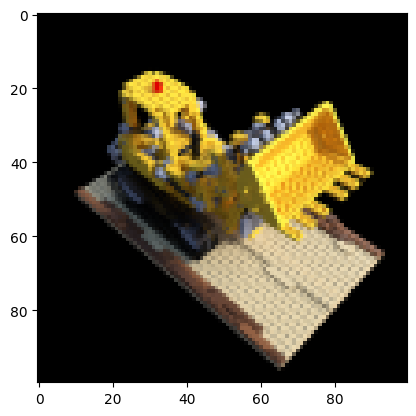

In [3]:
data = np.load('/content/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [4]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.19729608535766602 secs per iter


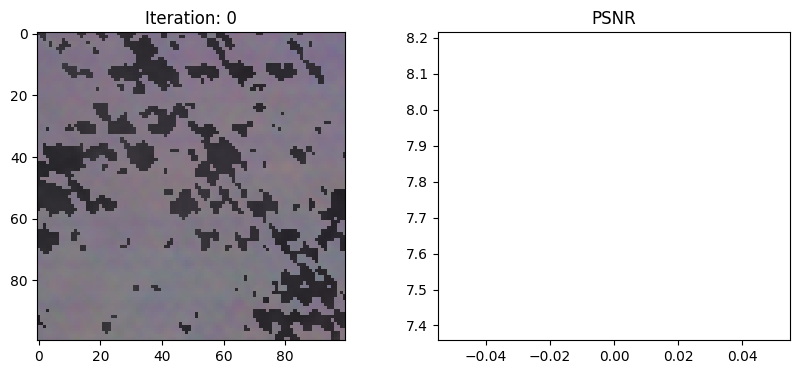

25 0.7043991756439208 secs per iter


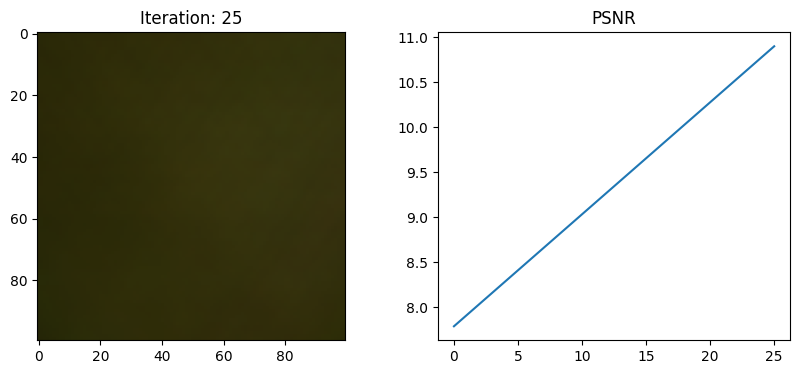

50 0.700037202835083 secs per iter


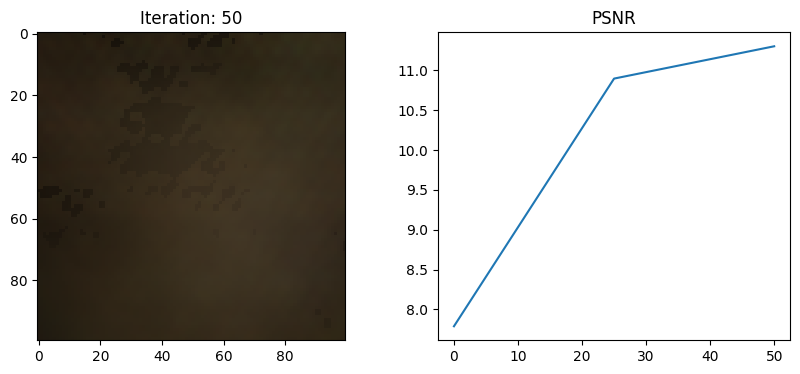

75 0.7352614402770996 secs per iter


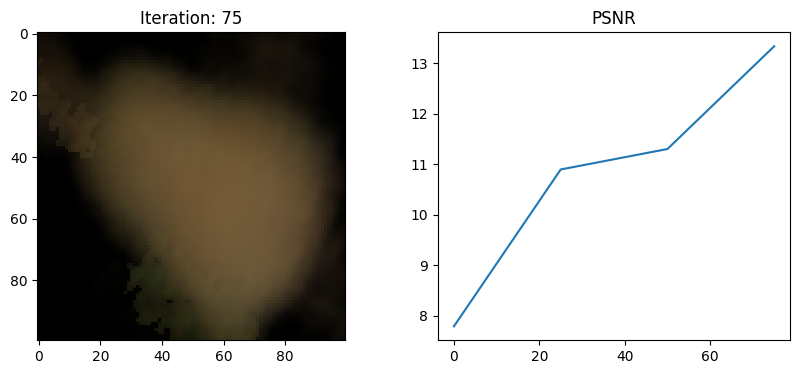

100 0.6888178825378418 secs per iter


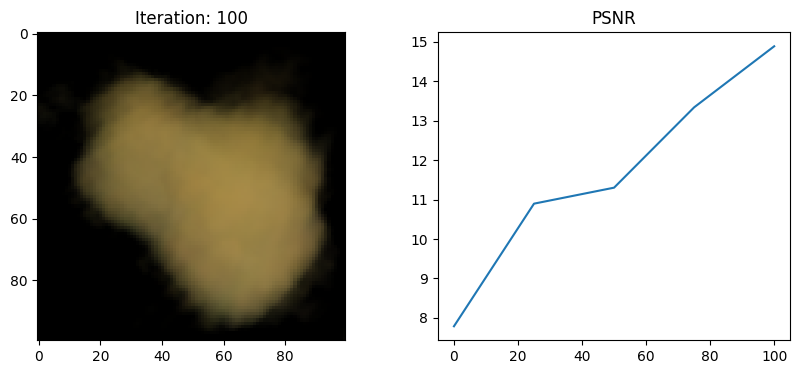

125 0.6855959129333496 secs per iter


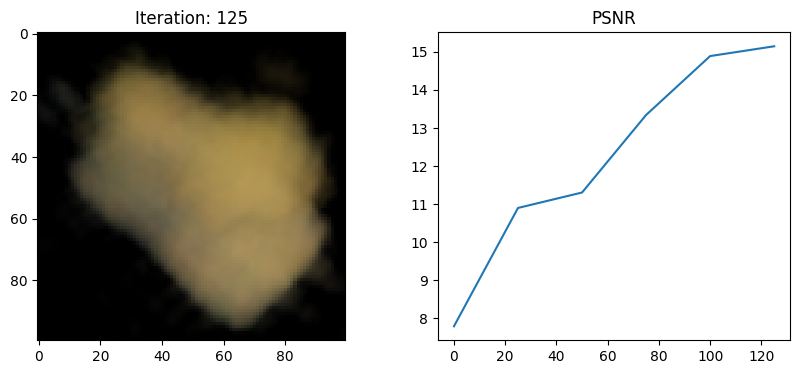

150 0.6896342372894287 secs per iter


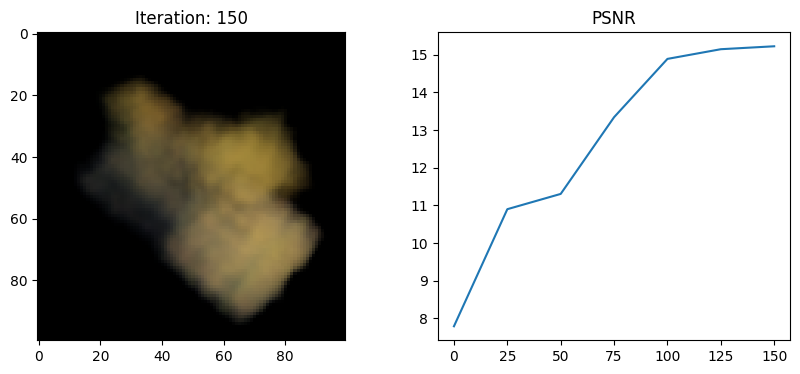

175 0.6745352172851562 secs per iter


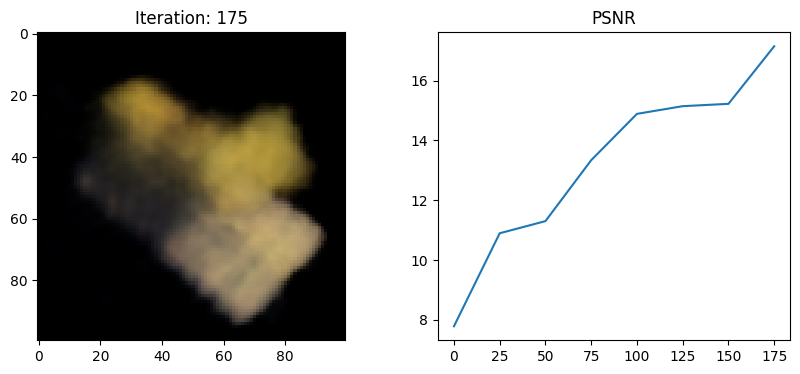

200 0.6734680461883545 secs per iter


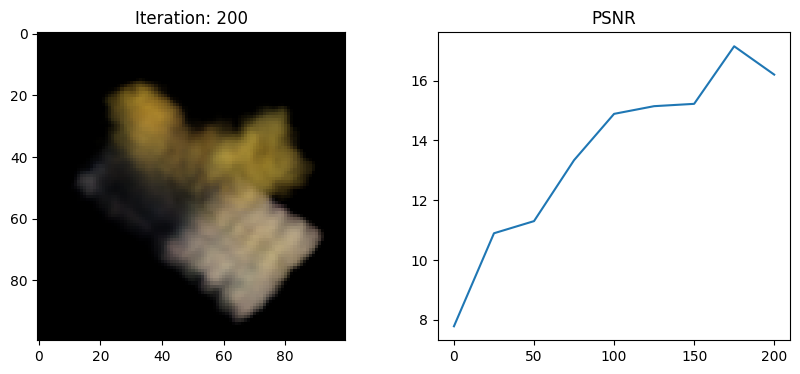

225 0.675896234512329 secs per iter


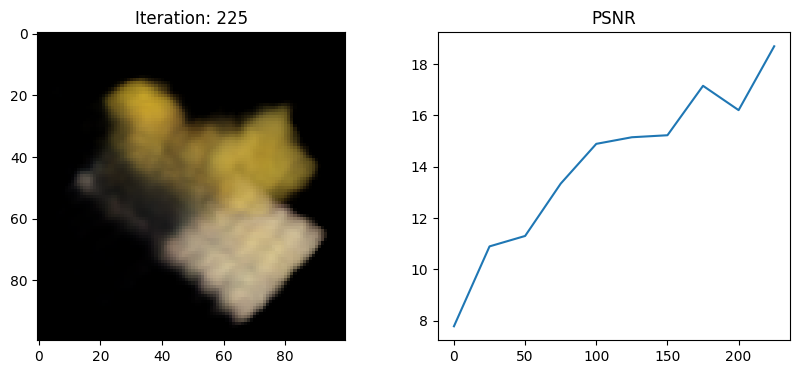

250 0.6765966701507569 secs per iter


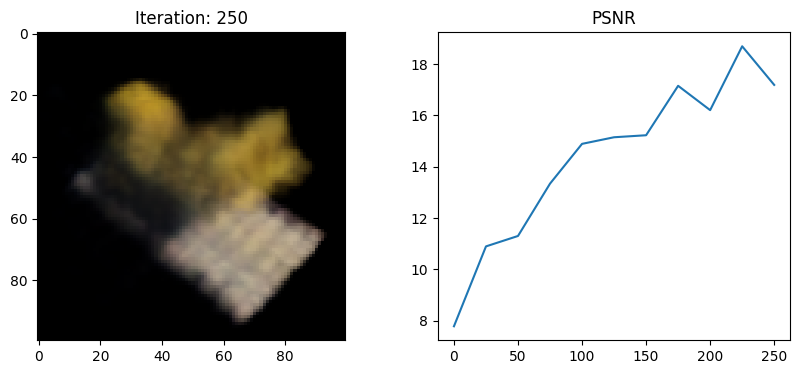

275 0.6822463130950928 secs per iter


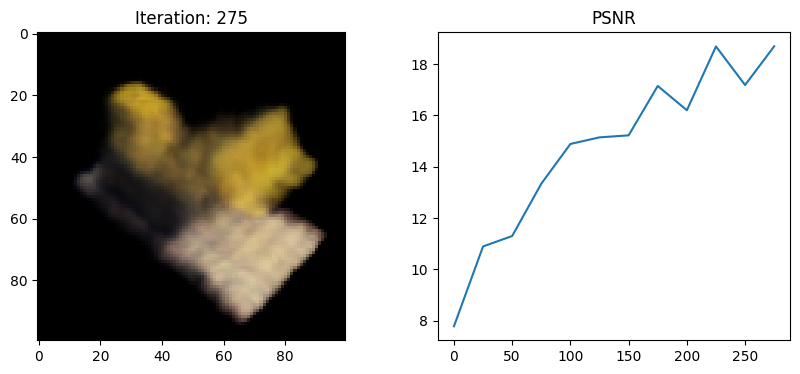

300 0.6735820293426513 secs per iter


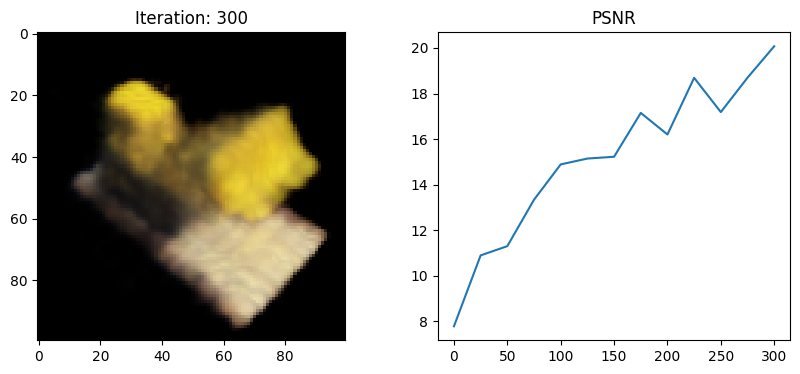

325 0.673364782333374 secs per iter


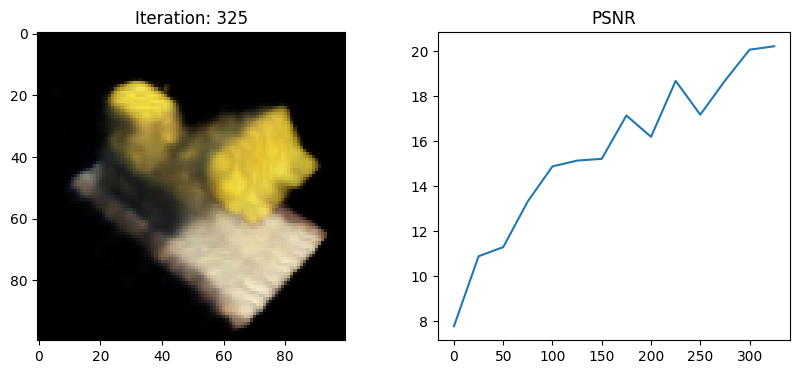

350 0.6737302684783936 secs per iter


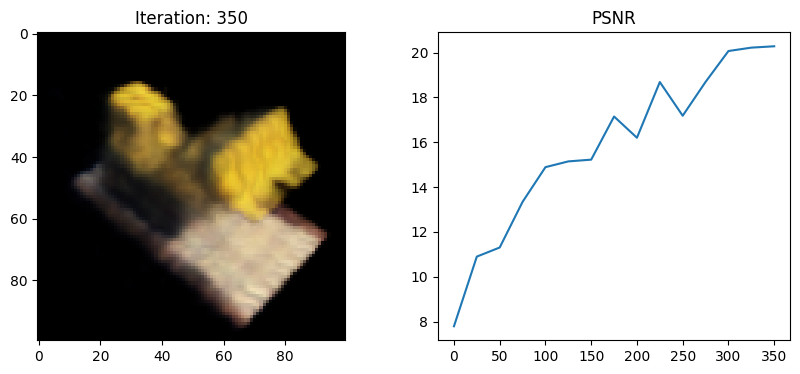

375 0.6773668766021729 secs per iter


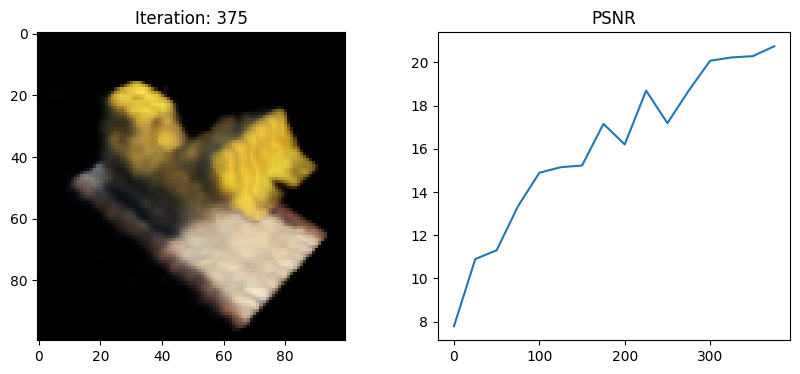

400 0.6841505336761474 secs per iter


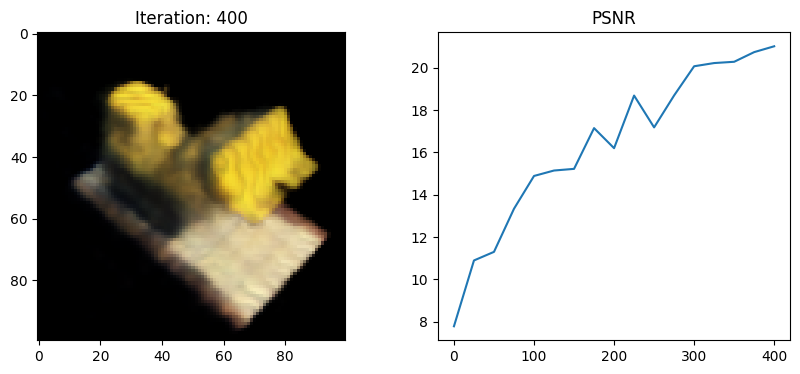

425 0.6763445568084717 secs per iter


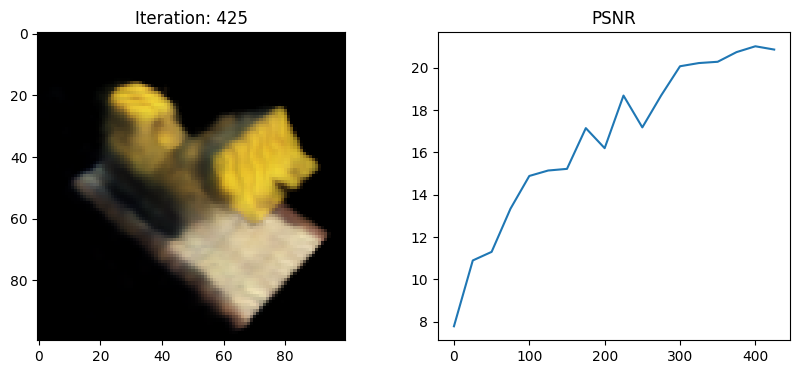

450 0.6756785488128663 secs per iter


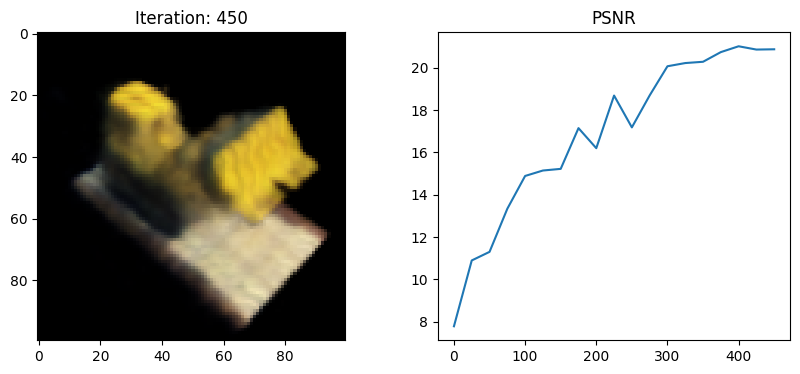

475 0.6733067893981933 secs per iter


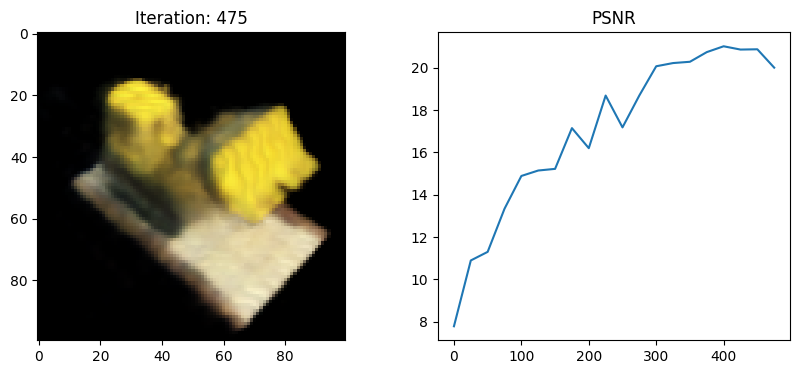

500 0.6827633666992188 secs per iter


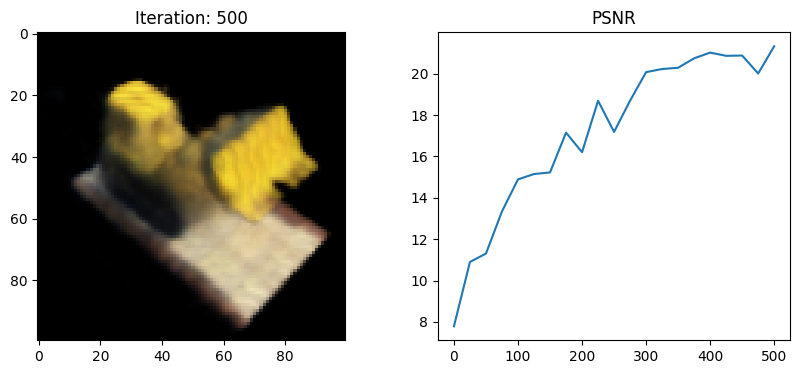

525 0.6777557182312012 secs per iter


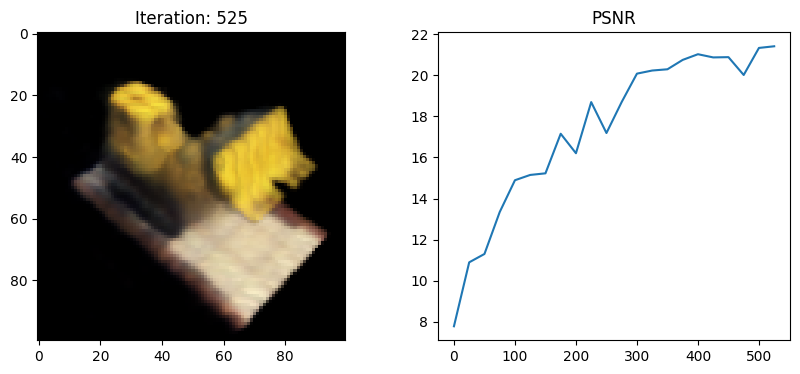

550 0.6744513320922851 secs per iter


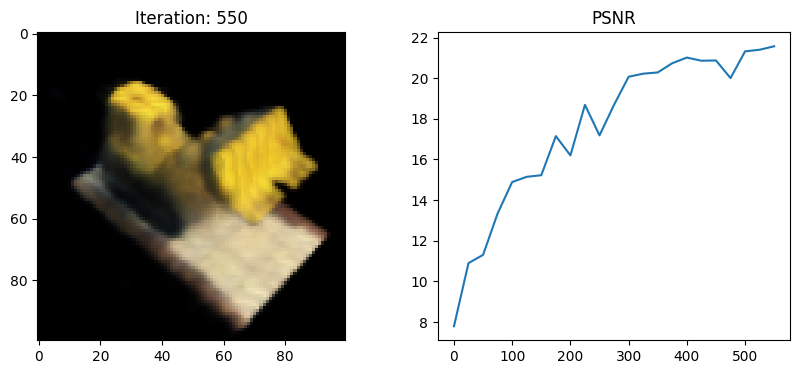

575 0.675421142578125 secs per iter


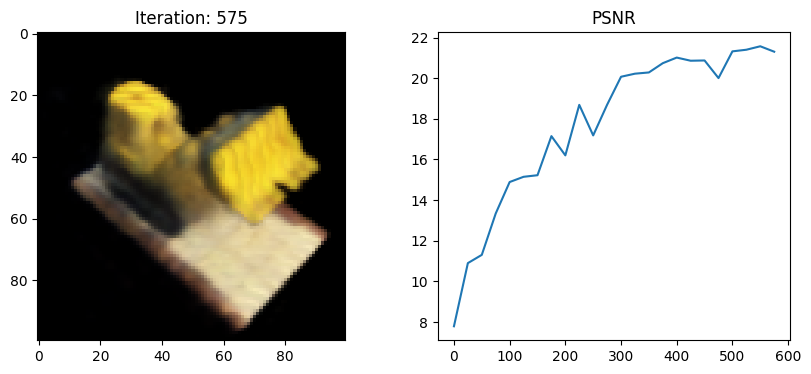

600 0.6755683422088623 secs per iter


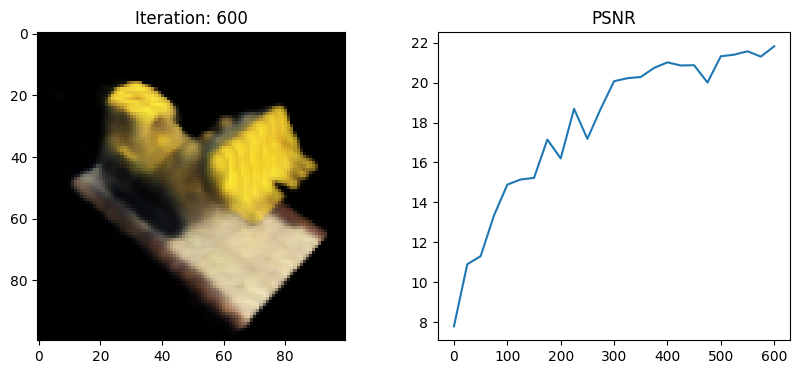

625 0.6771513938903808 secs per iter


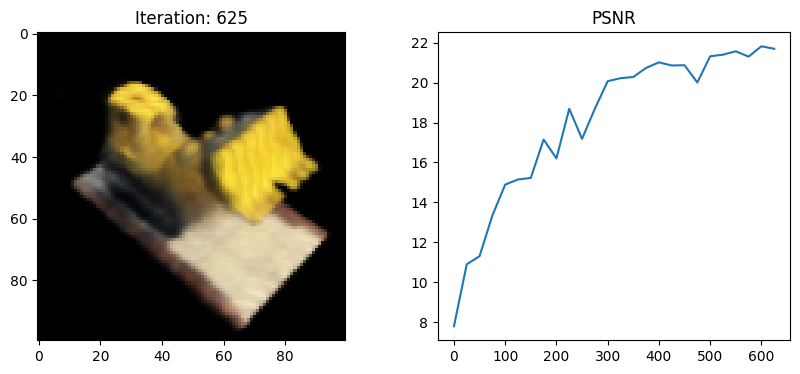

650 0.6720294094085694 secs per iter


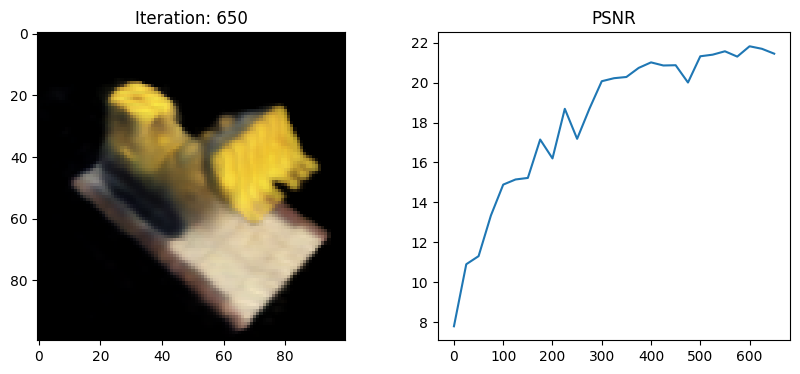

675 0.6755872917175293 secs per iter


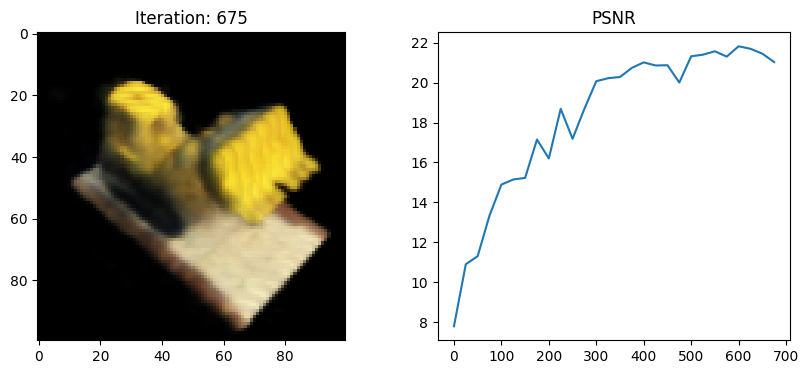

700 0.6770877075195313 secs per iter


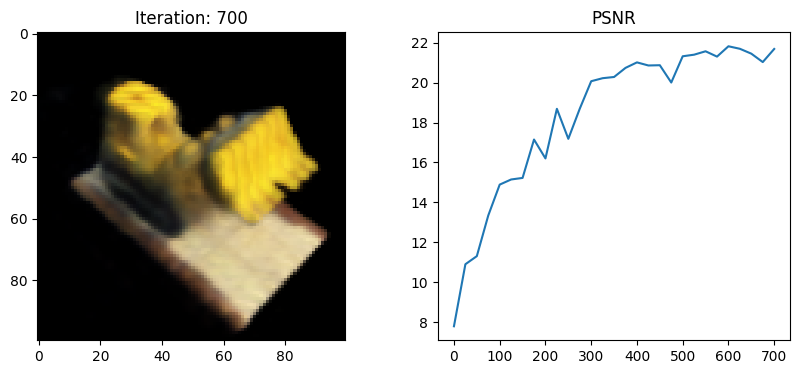

725 0.6735727119445801 secs per iter


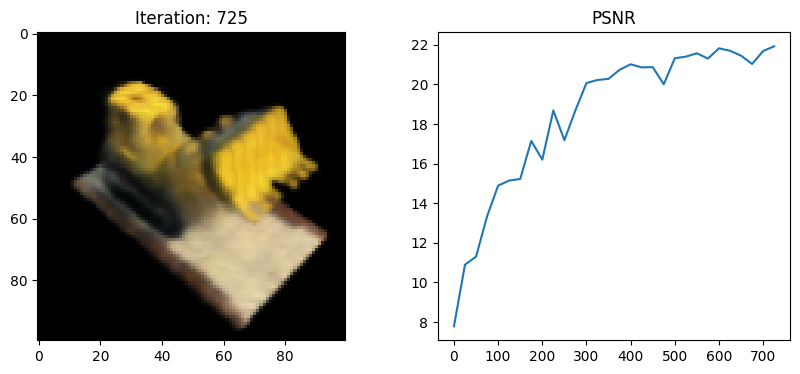

750 0.6755313682556152 secs per iter


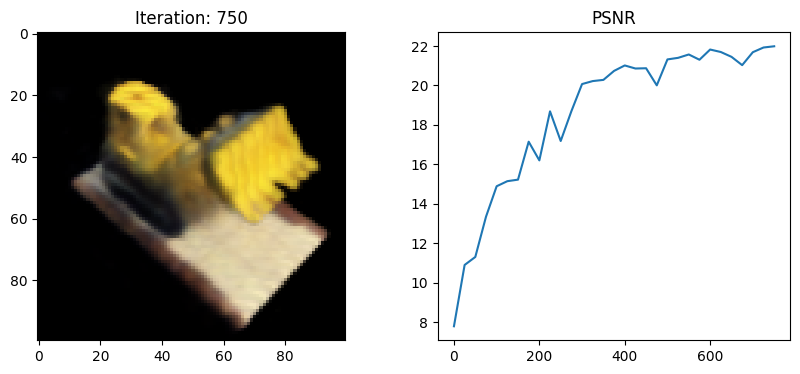

775 0.6715364170074463 secs per iter


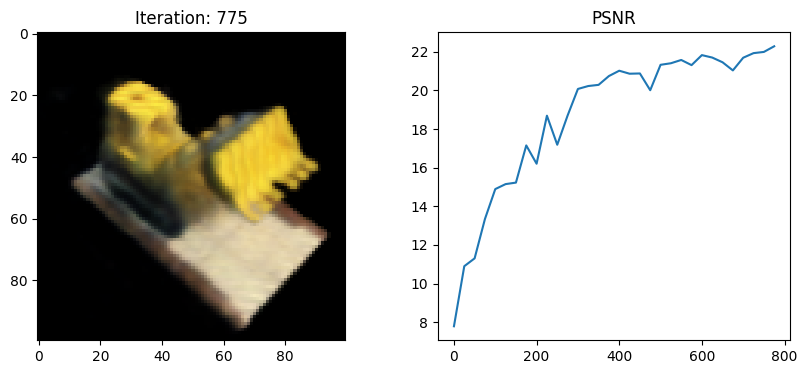

800 0.6742909908294678 secs per iter


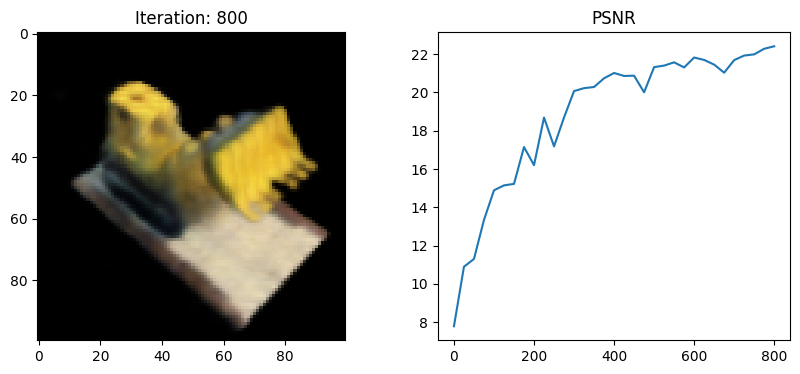

825 0.6741929531097413 secs per iter


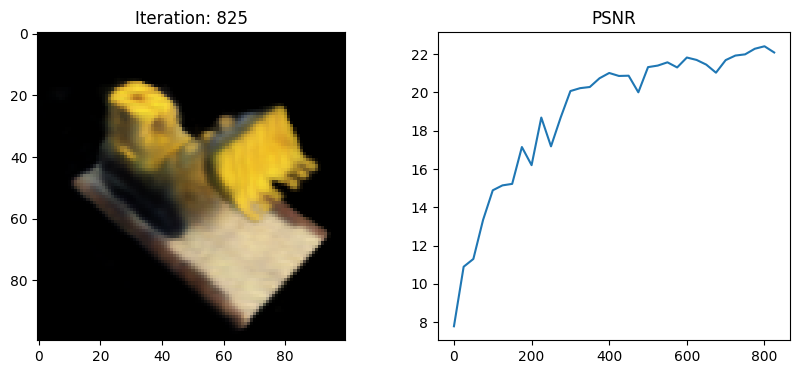

850 0.6804376316070556 secs per iter


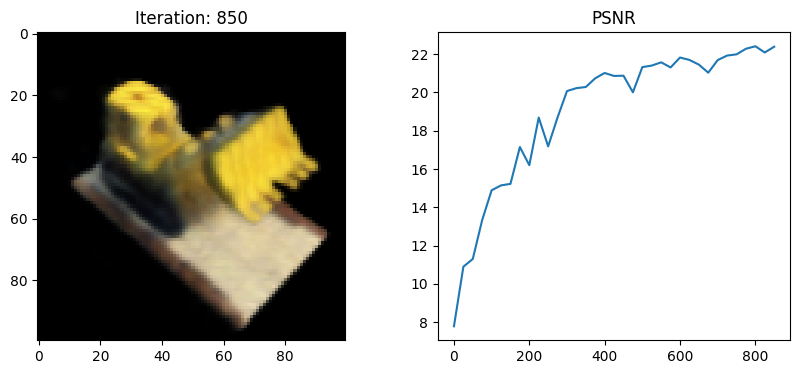

875 0.6769005966186523 secs per iter


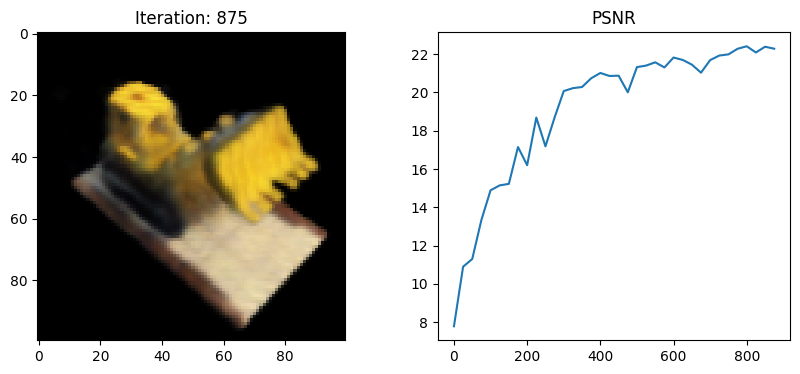

900 0.6706079578399659 secs per iter


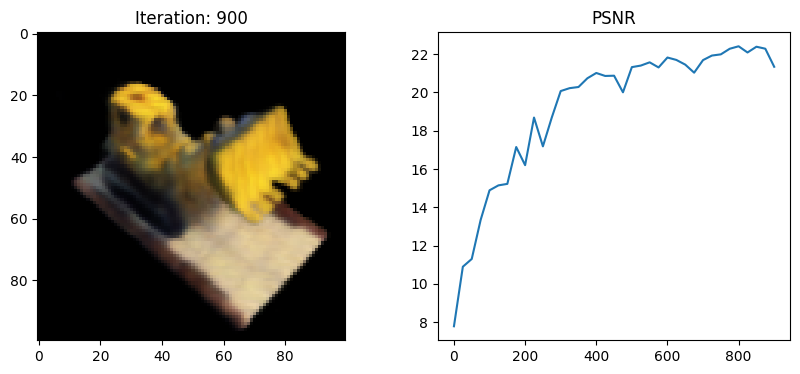

925 0.6736760902404785 secs per iter


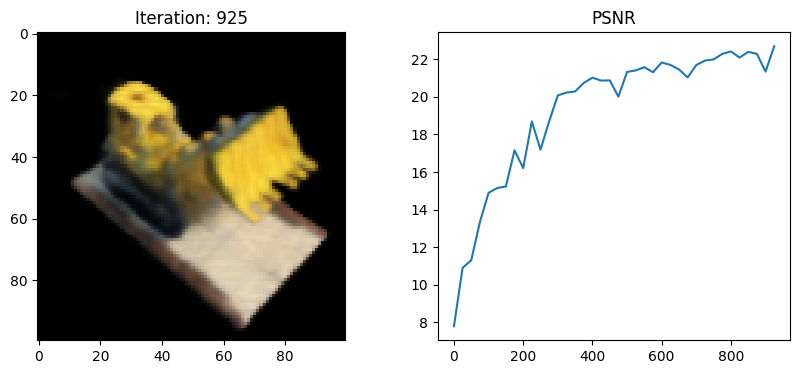

950 0.6785962390899658 secs per iter


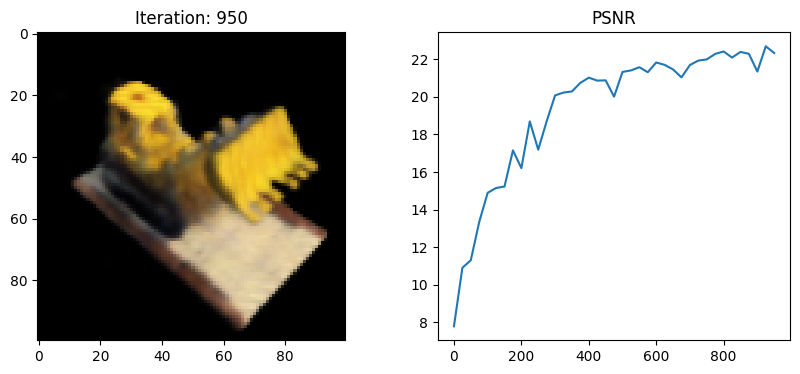

975 0.6731687927246094 secs per iter


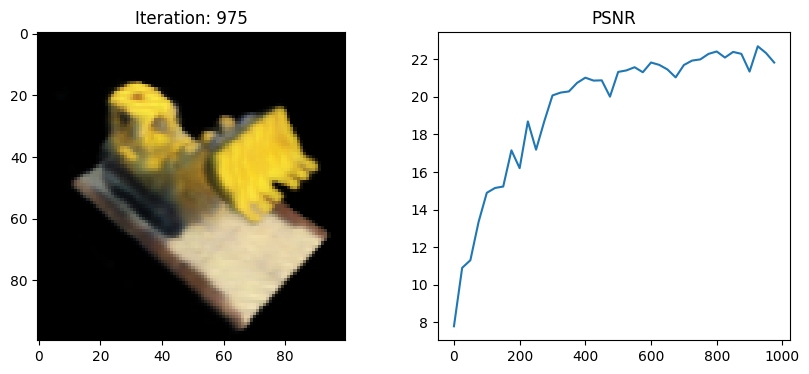

1000 0.676099271774292 secs per iter


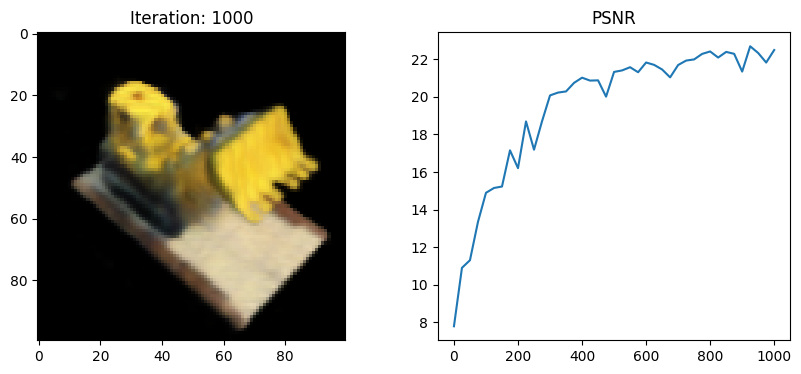

1025 0.6693841361999512 secs per iter


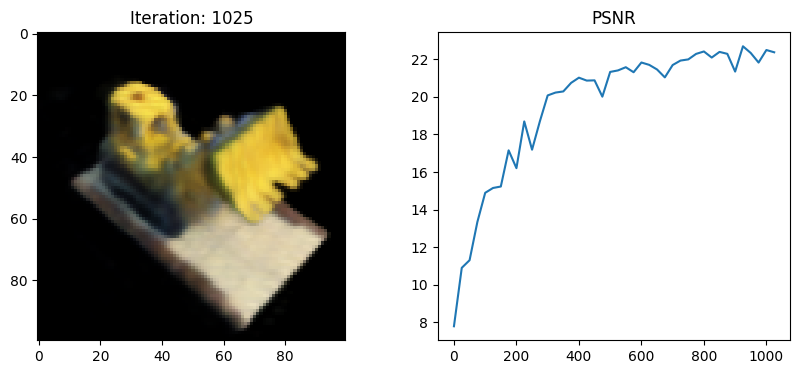

1050 0.6713515377044678 secs per iter


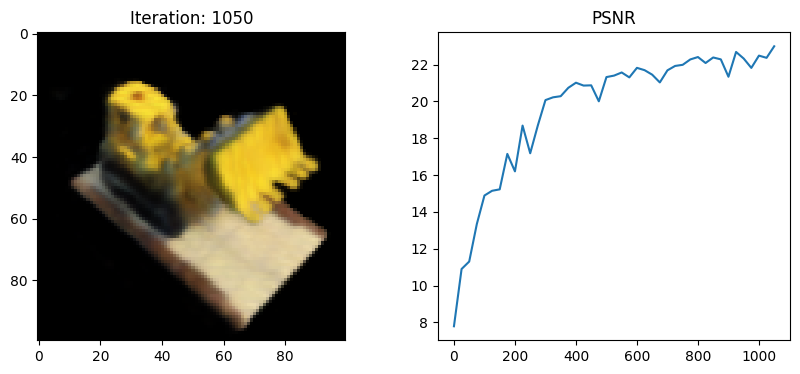

1075 0.6785562324523926 secs per iter


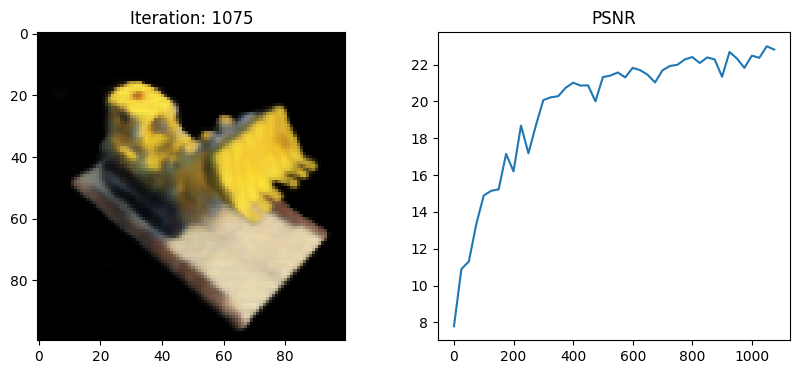

1100 0.6735165691375733 secs per iter


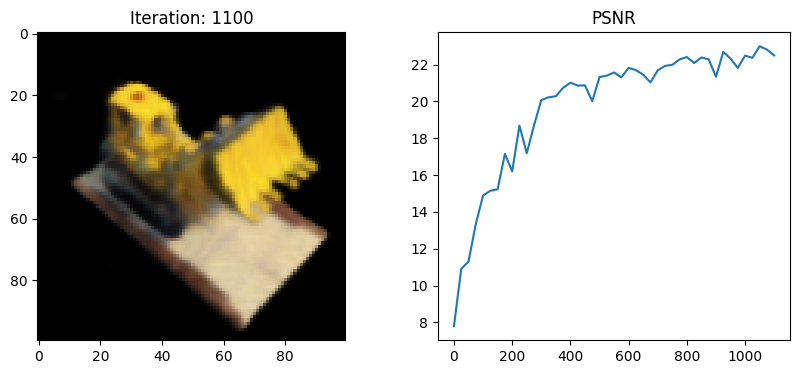

1125 0.6735881805419922 secs per iter


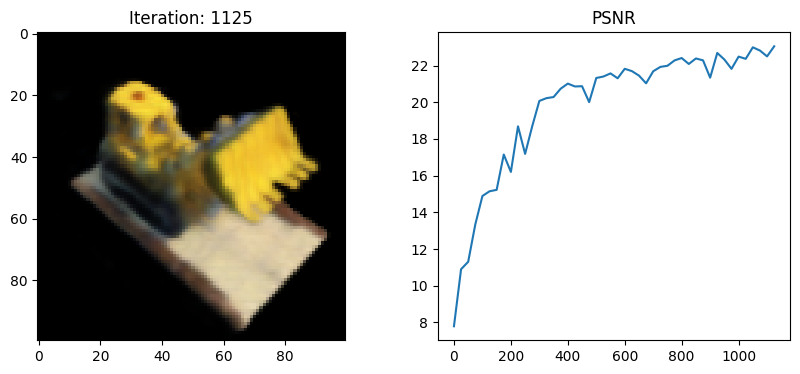

1150 0.6723406982421875 secs per iter


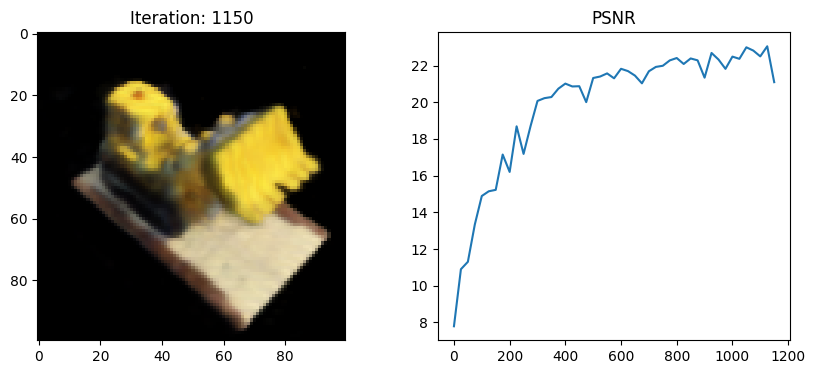

1175 0.6723589229583741 secs per iter


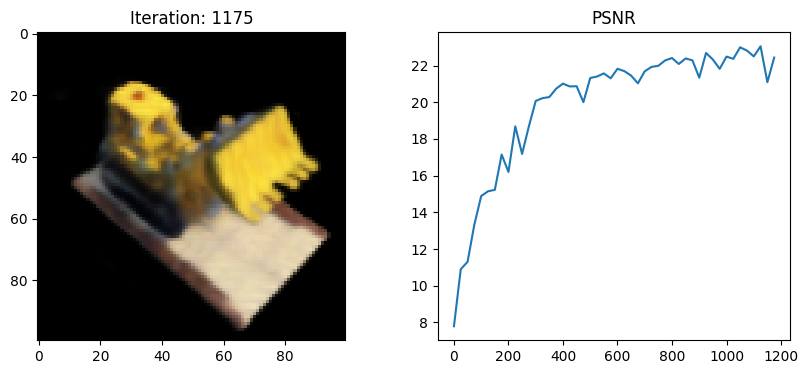

1200 0.6906239223480225 secs per iter


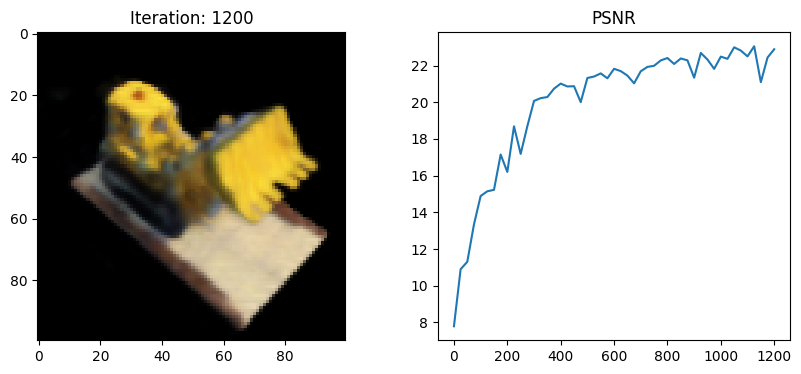

1225 0.6718564224243164 secs per iter


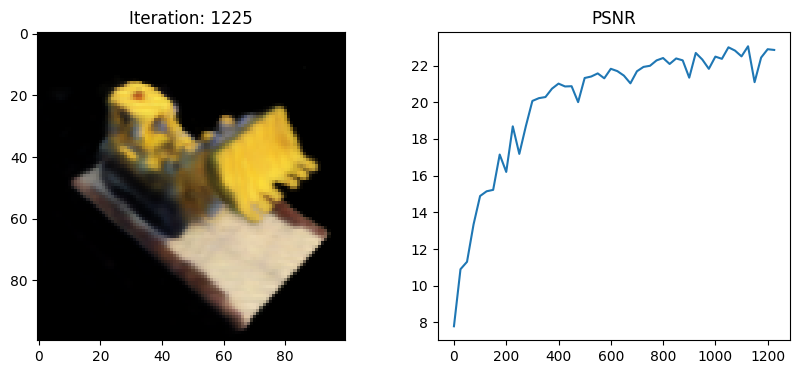

1250 0.6734330368041992 secs per iter


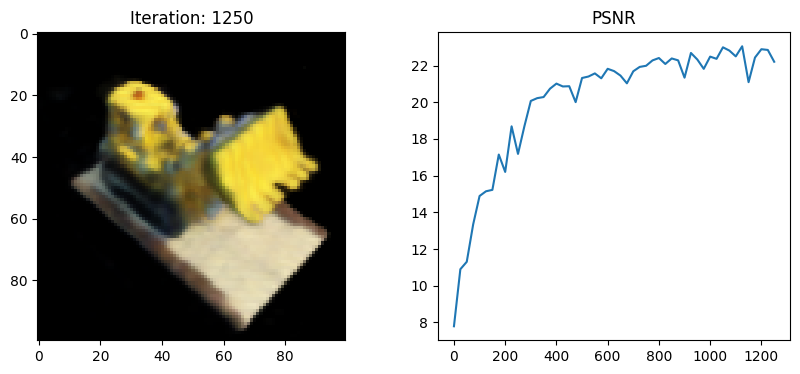

1275 0.7500320529937744 secs per iter


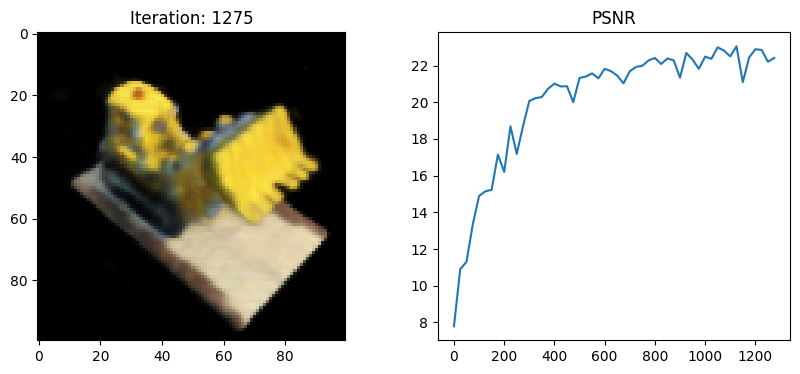

1300 0.6759316921234131 secs per iter


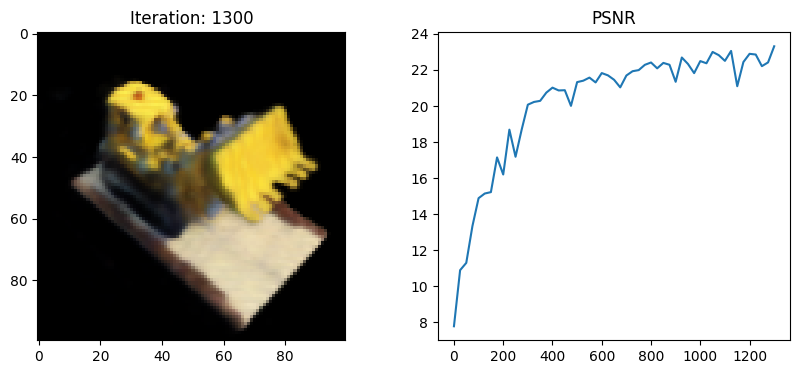

1325 0.6737070560455323 secs per iter


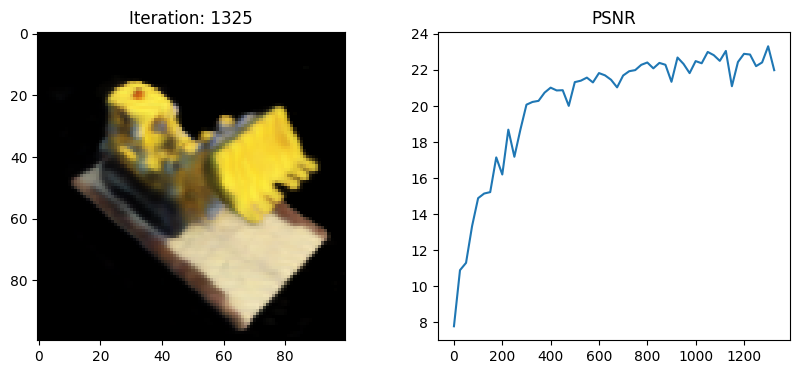

1350 0.6840401268005372 secs per iter


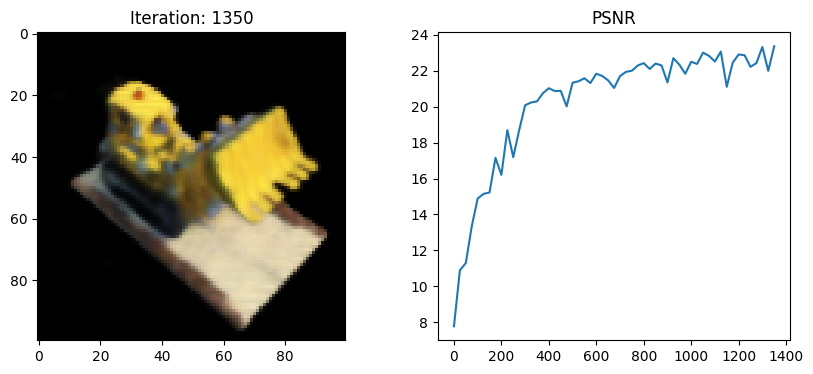

1375 0.7270674896240235 secs per iter


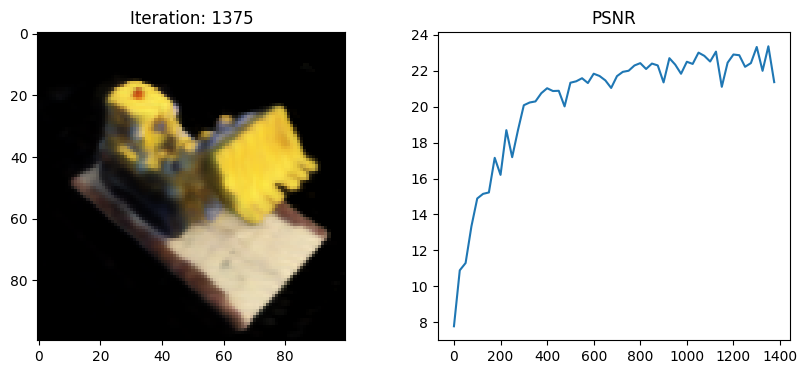

1400 0.6746180915832519 secs per iter


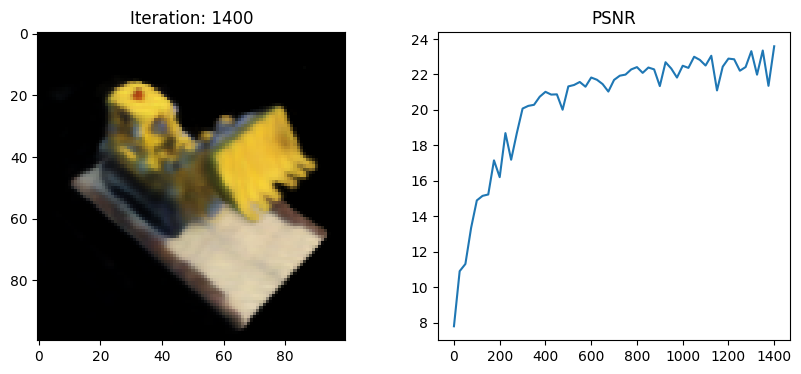

1425 0.6759474277496338 secs per iter


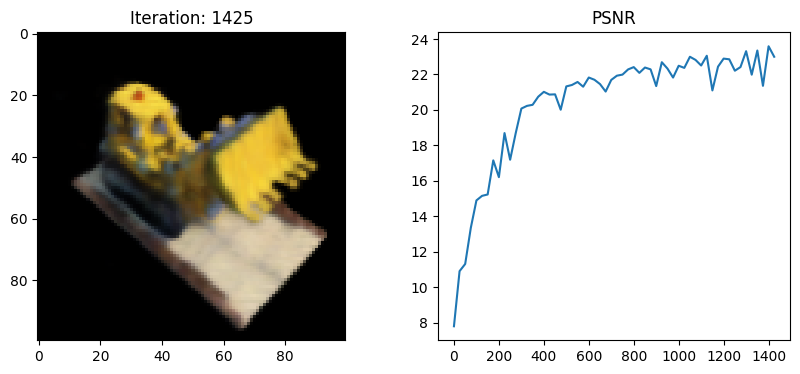

1450 0.7289143657684326 secs per iter


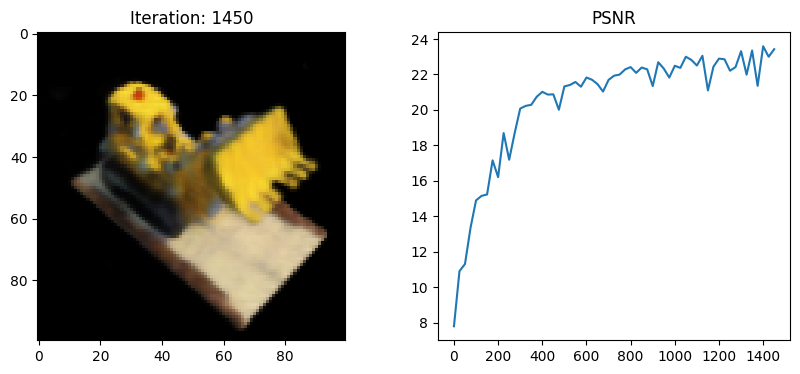

1475 0.6759627914428711 secs per iter


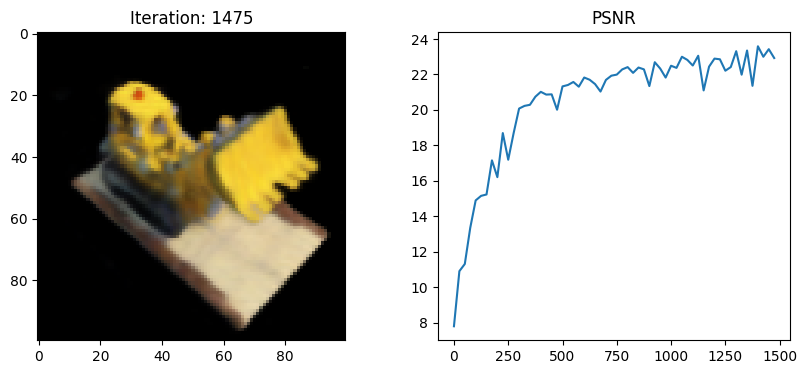

1500 0.6720250034332276 secs per iter


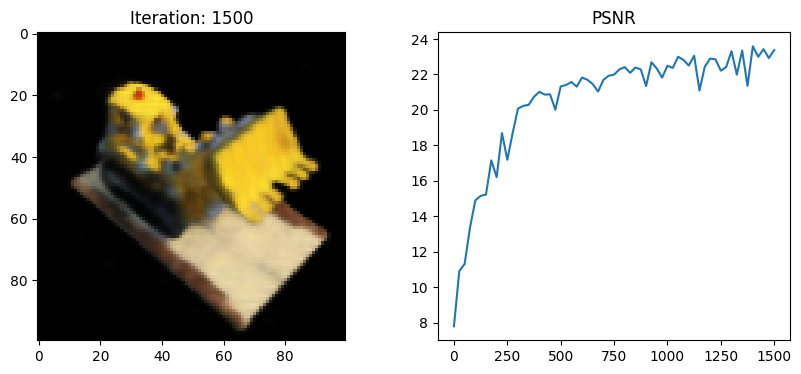

1525 0.6892486381530761 secs per iter


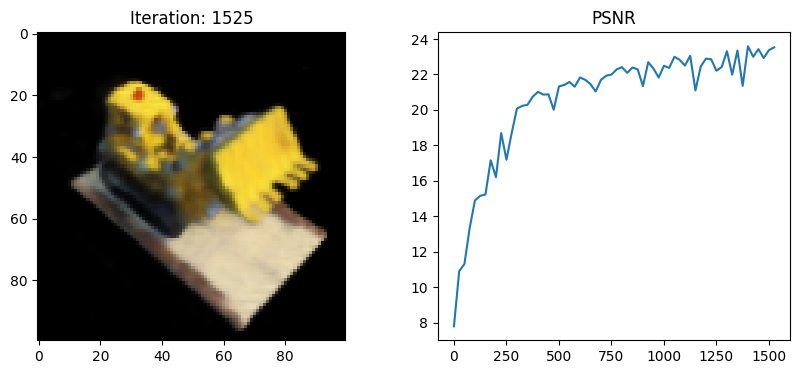

1550 0.7319430065155029 secs per iter


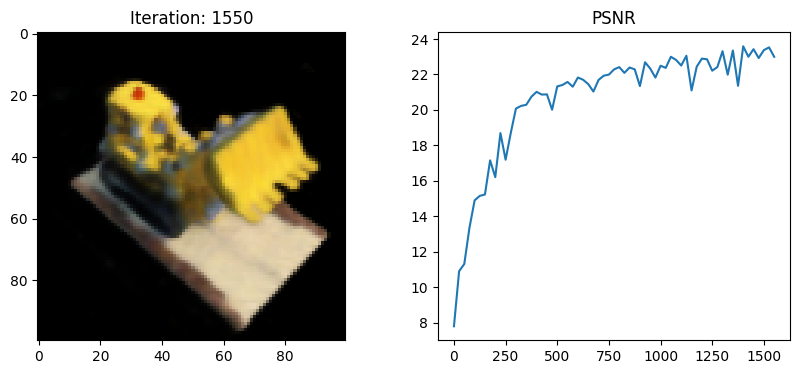

1575 0.6748686027526856 secs per iter


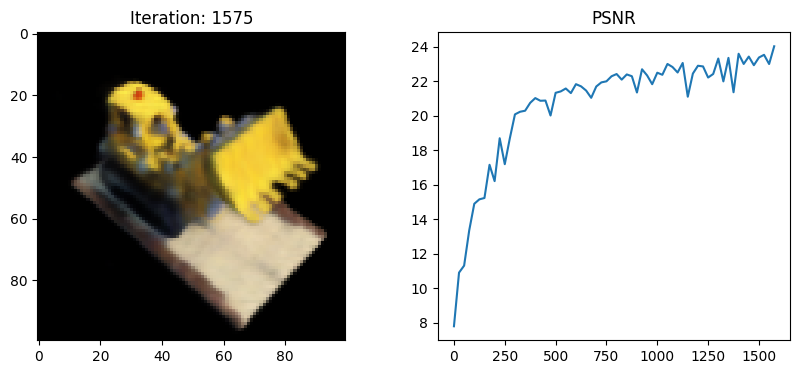

1600 0.6777811527252198 secs per iter


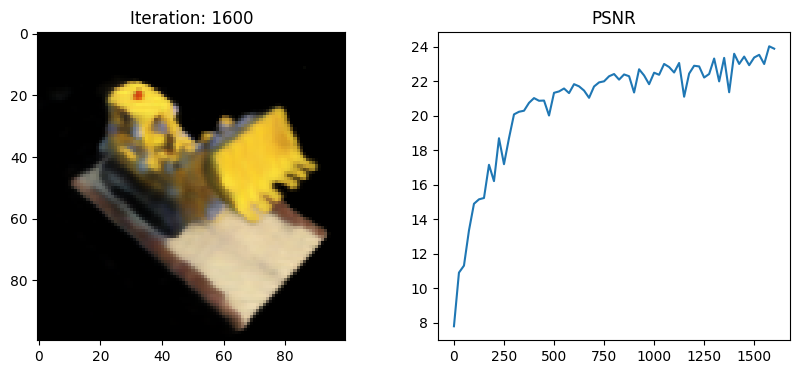

1625 0.7123989963531494 secs per iter


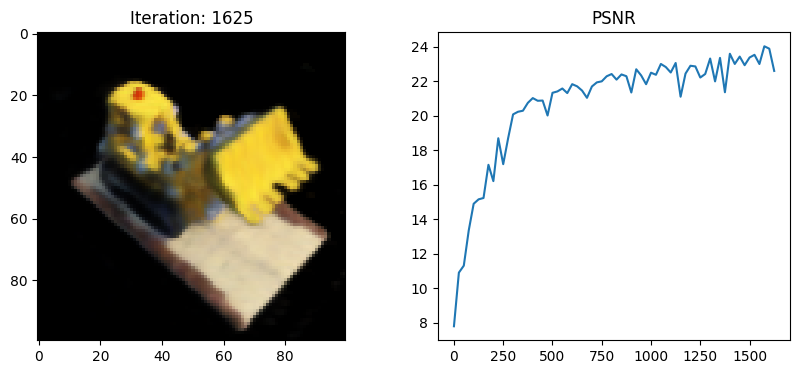

1650 0.6762083053588868 secs per iter


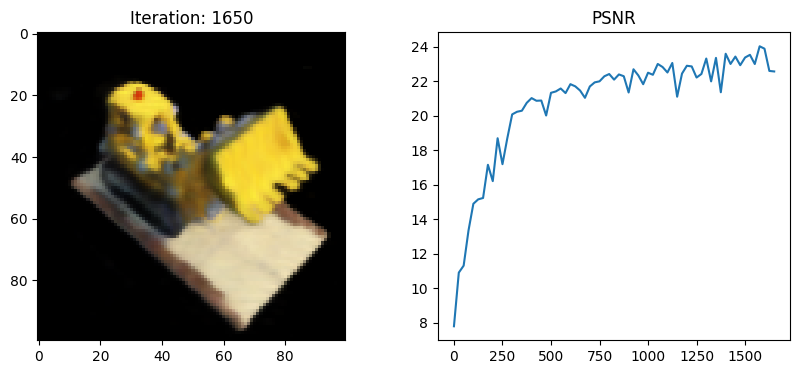

1675 0.6727906131744384 secs per iter


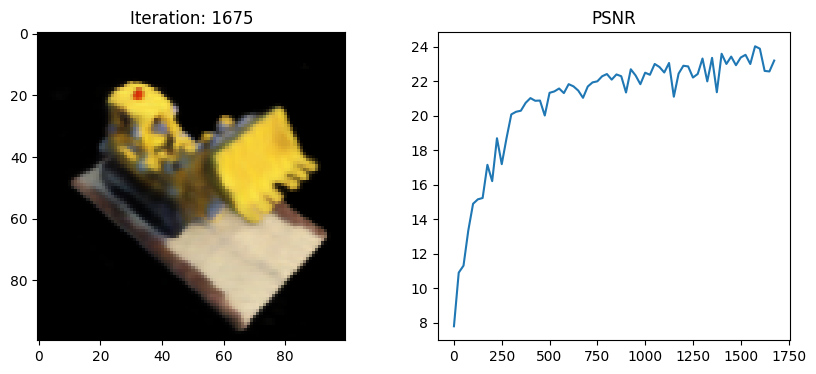

1700 0.7038333892822266 secs per iter


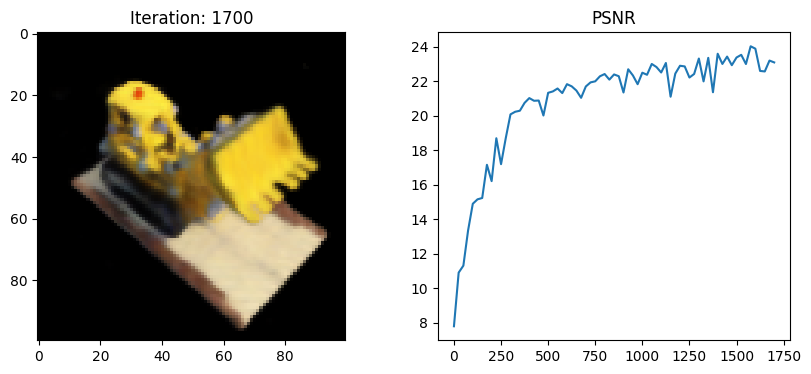

1725 0.7245902442932128 secs per iter


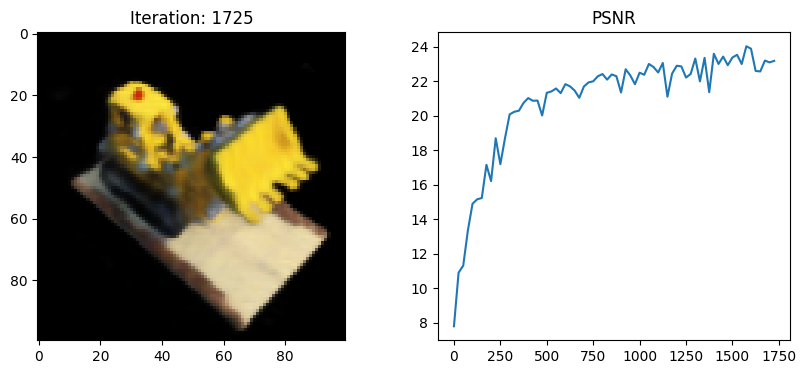

1750 0.6811792850494385 secs per iter


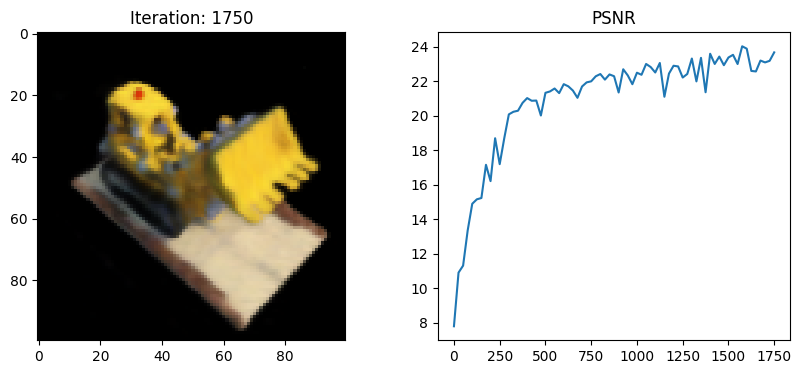

1775 0.6786174583435058 secs per iter


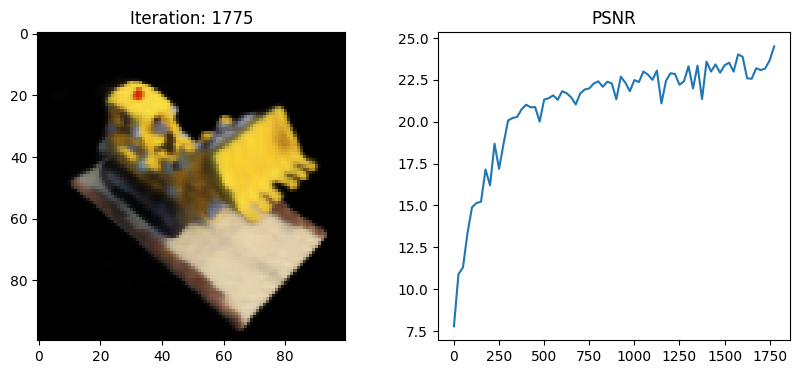

1800 0.680857400894165 secs per iter


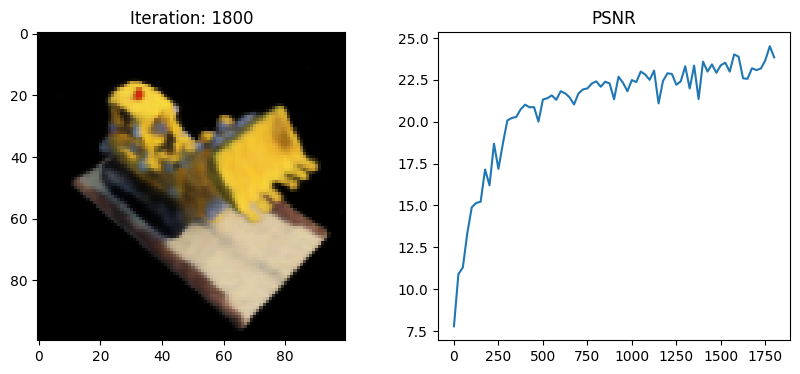

1825 0.6758254146575928 secs per iter


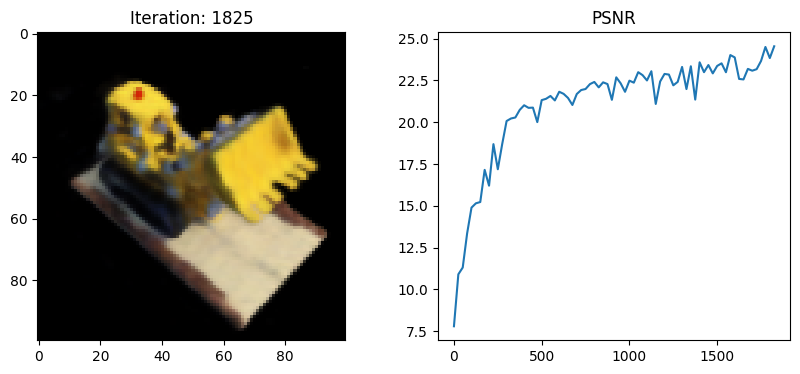

1850 0.6794018745422363 secs per iter


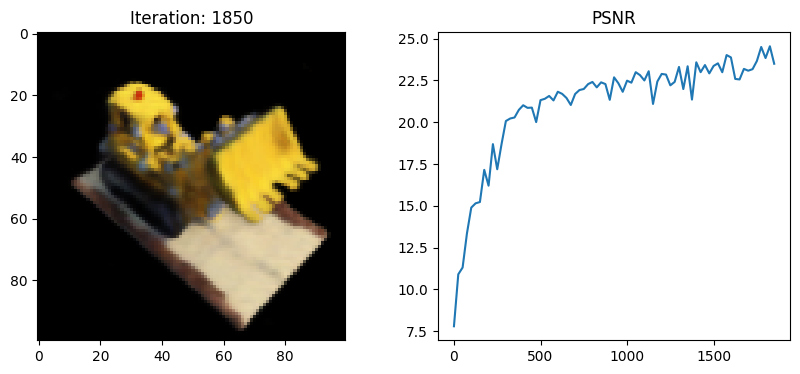

1875 0.6944096851348877 secs per iter


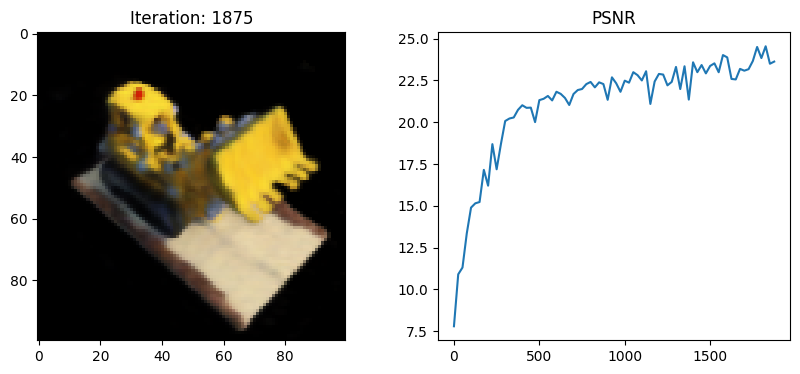

1900 0.6823085117340087 secs per iter


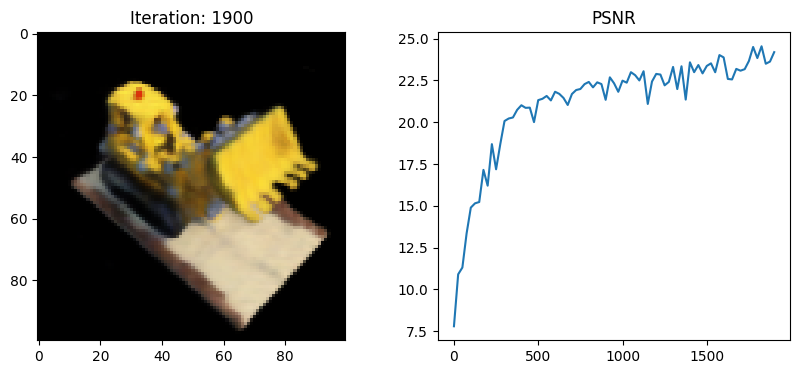

1925 0.6743611335754395 secs per iter


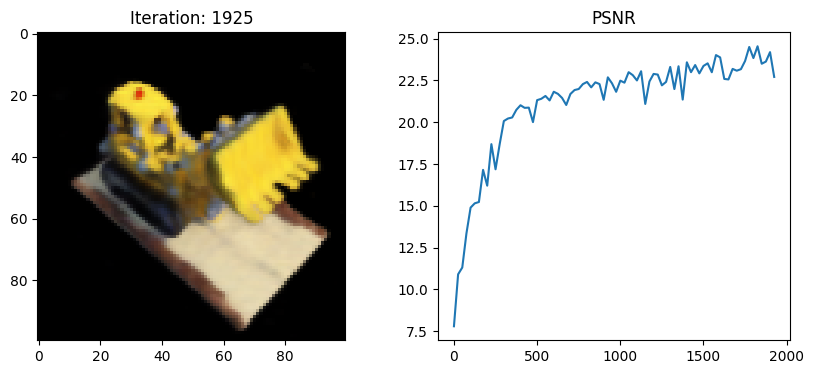

1950 0.6760313701629639 secs per iter


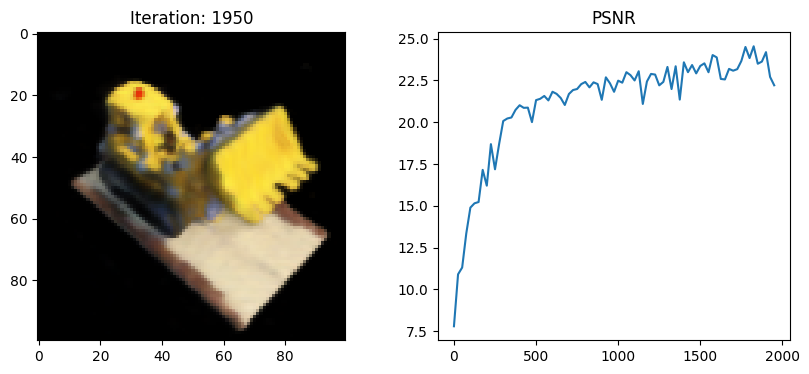

1975 0.6874235916137695 secs per iter


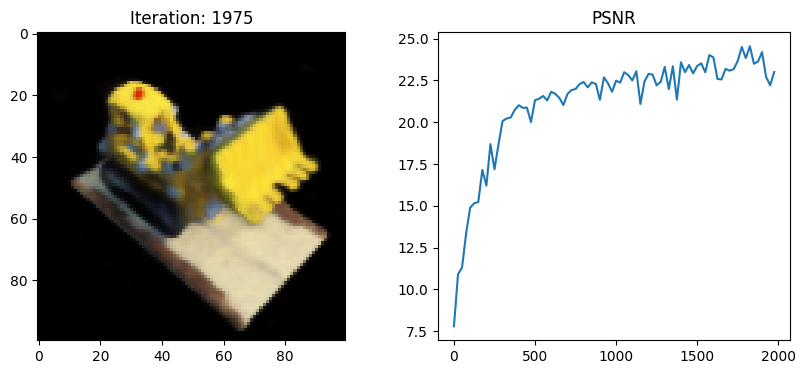

2000 0.674196720123291 secs per iter


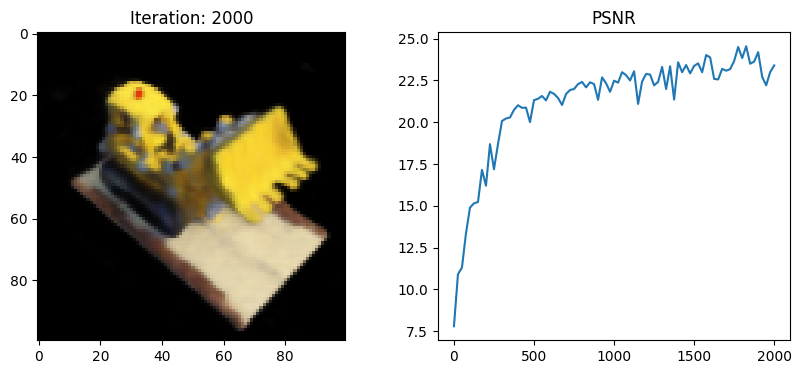

2025 0.6792194175720215 secs per iter


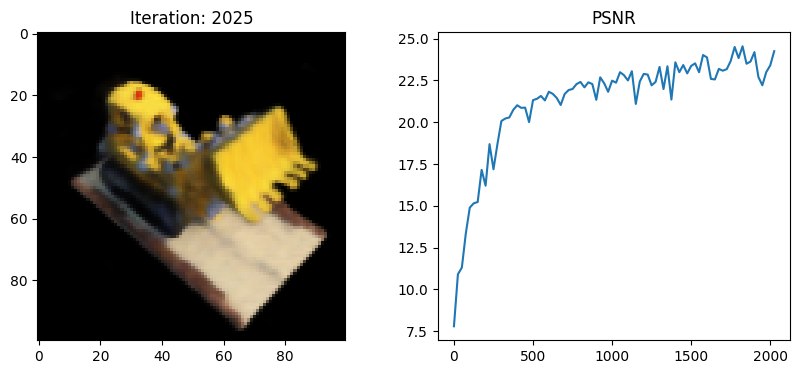

2050 0.6734992122650146 secs per iter


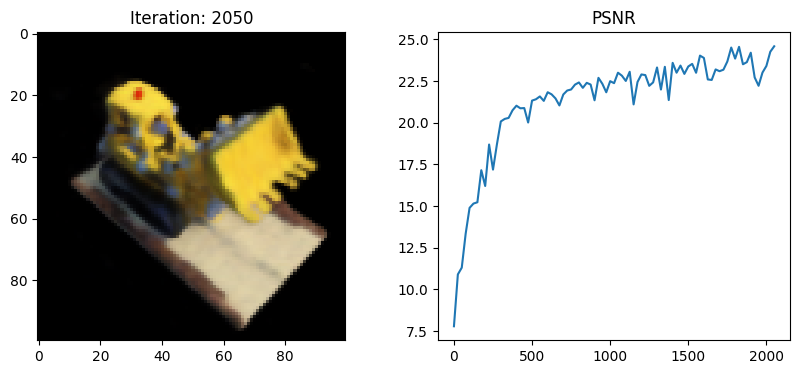

2075 0.6736736965179443 secs per iter


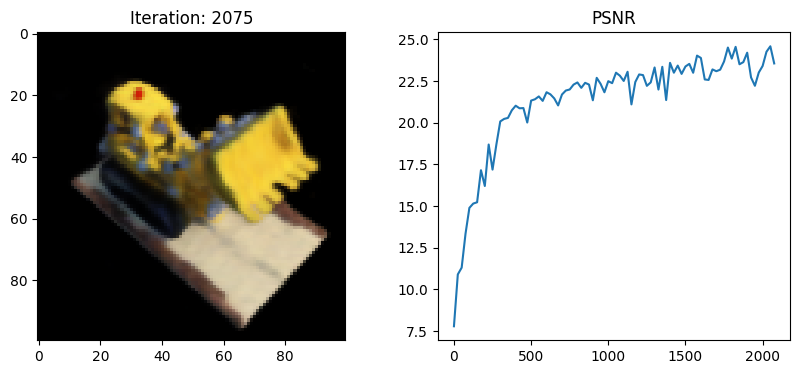

2100 0.7102136135101318 secs per iter


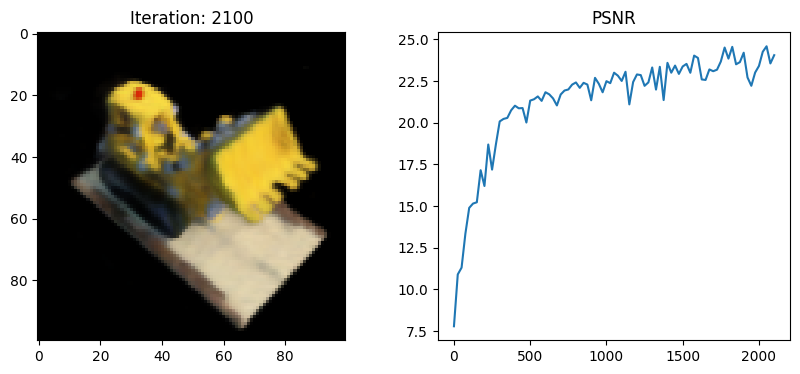

2125 0.7211410236358643 secs per iter


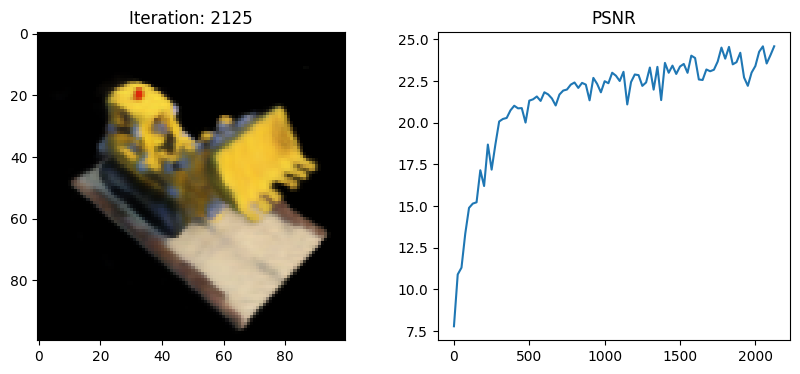

2150 0.6992022228240967 secs per iter


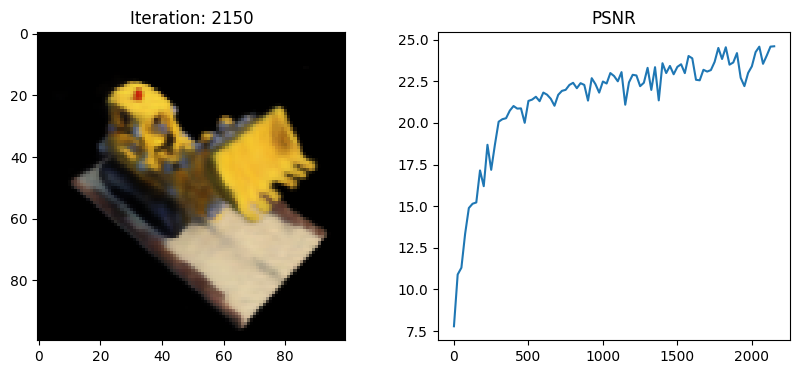

2175 0.6751674175262451 secs per iter


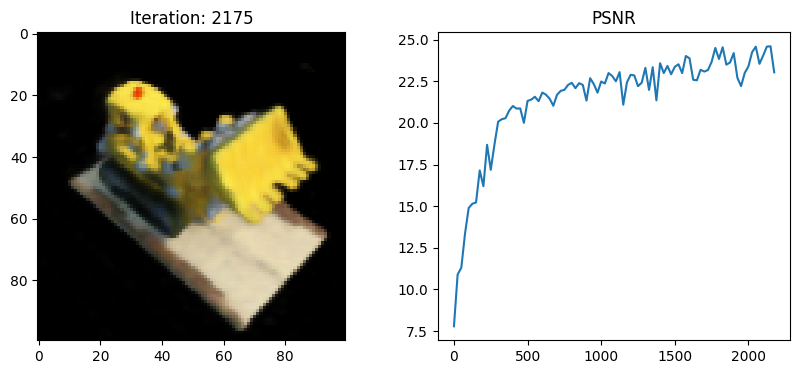

2200 0.6825319957733155 secs per iter


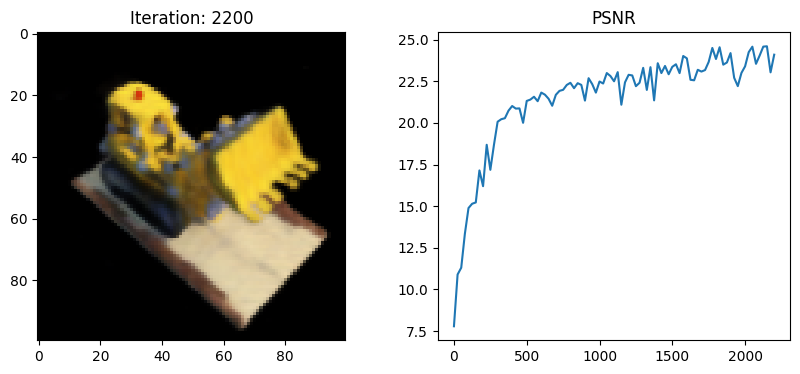

2225 0.7228930950164795 secs per iter


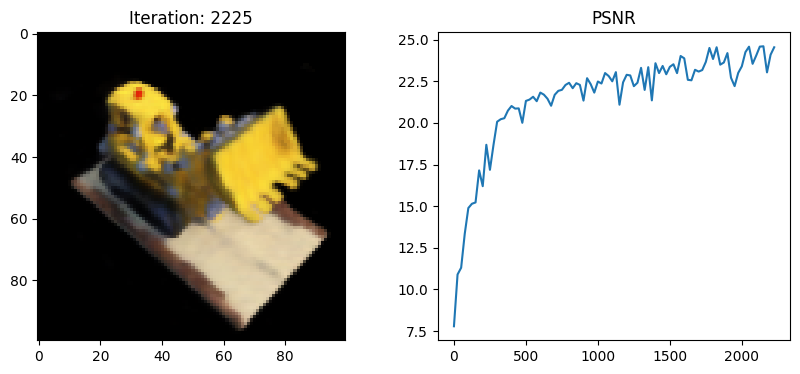

2250 0.6827322673797608 secs per iter


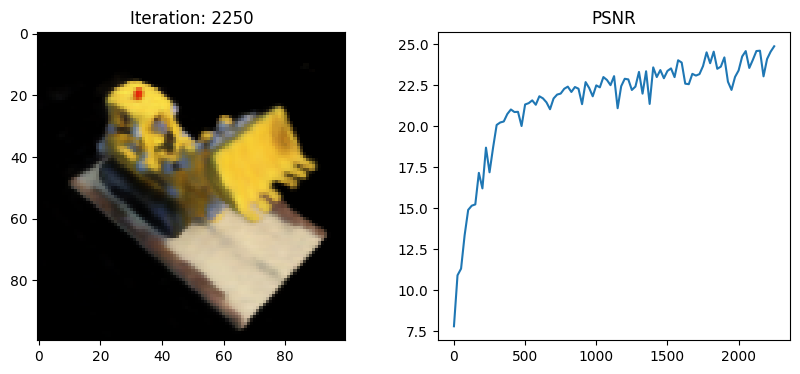

2275 0.6748575592041015 secs per iter


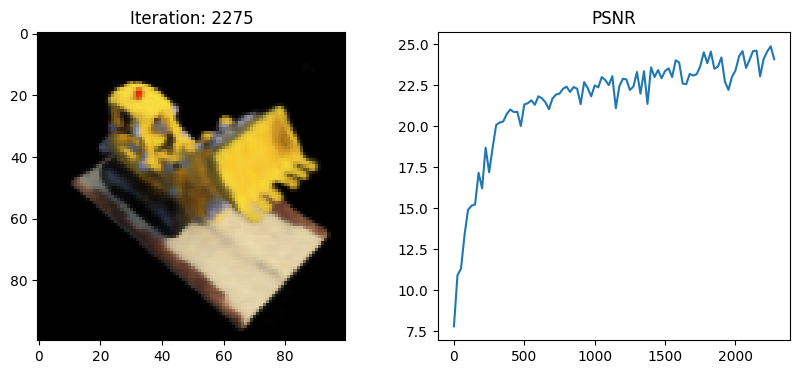

2300 0.6756712913513183 secs per iter


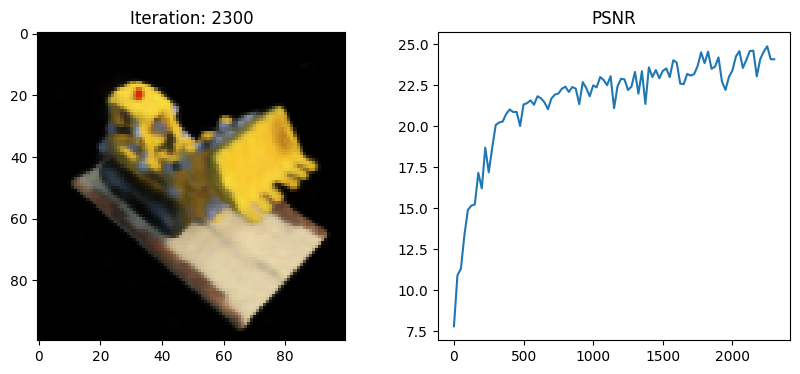

2325 0.6794421482086181 secs per iter


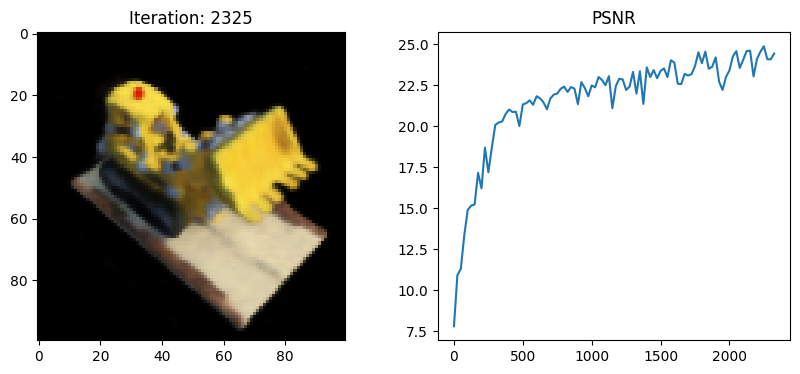

2350 0.6755397415161133 secs per iter


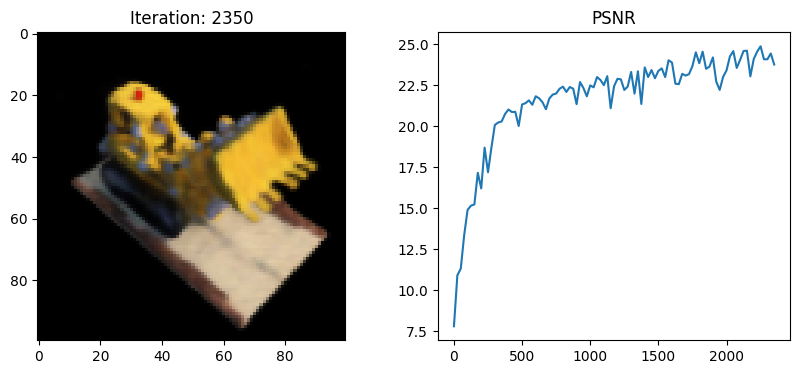

2375 0.6809640502929688 secs per iter


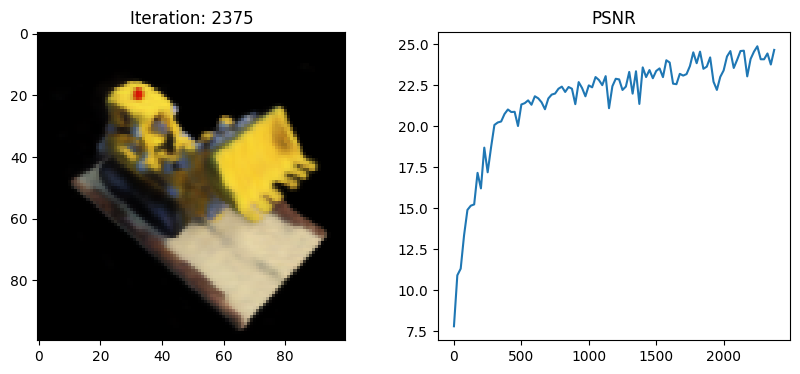

2400 0.6749331760406494 secs per iter


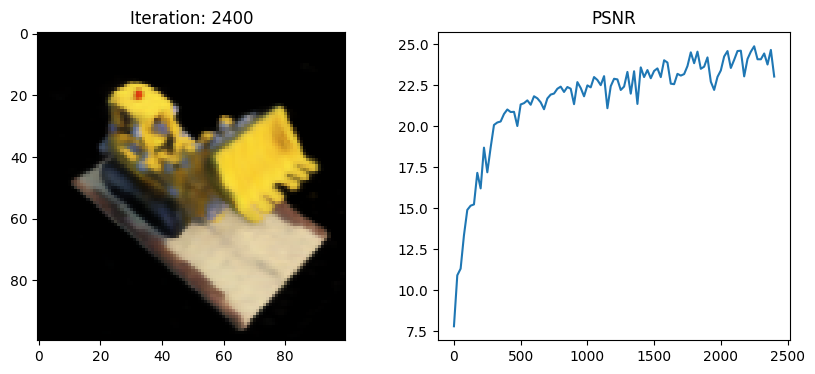

2425 0.6754150104522705 secs per iter


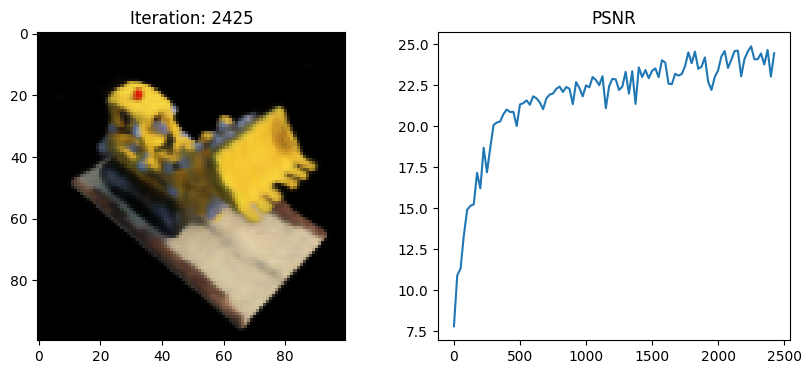

2450 0.6731823921203614 secs per iter


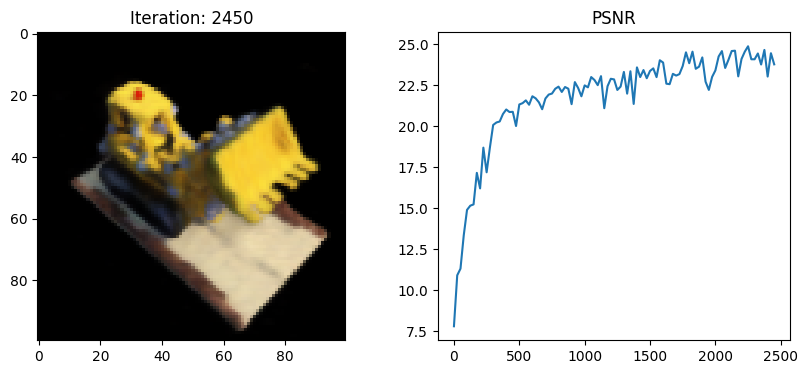

2475 0.6853925704956054 secs per iter


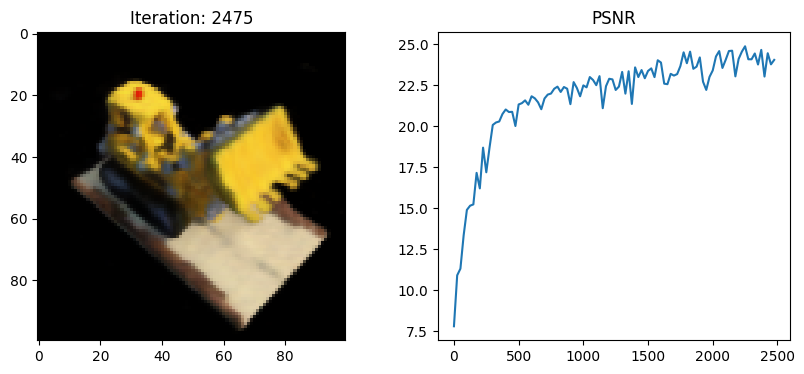

2500 0.683462610244751 secs per iter


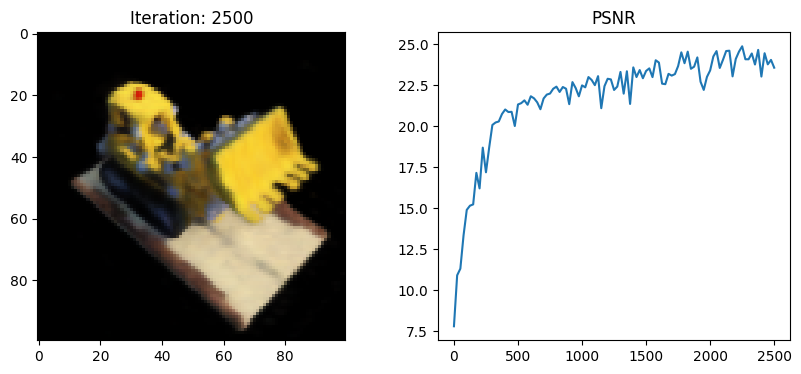

2525 0.673340892791748 secs per iter


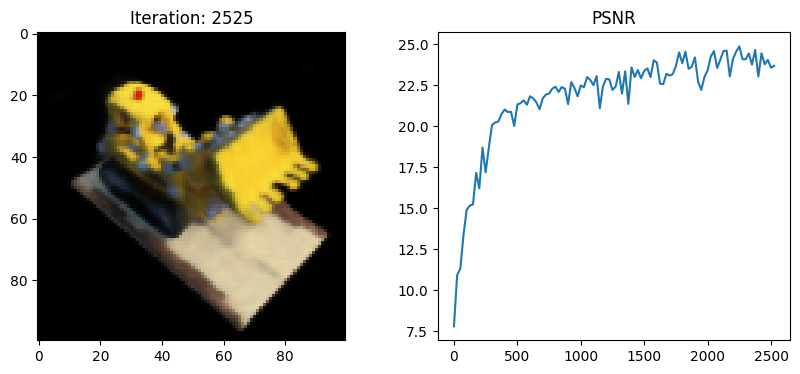

2550 0.6957639503479004 secs per iter


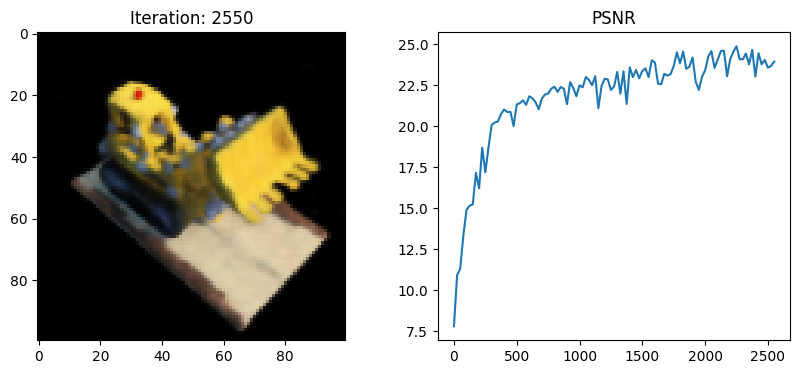

2575 0.7198619747161865 secs per iter


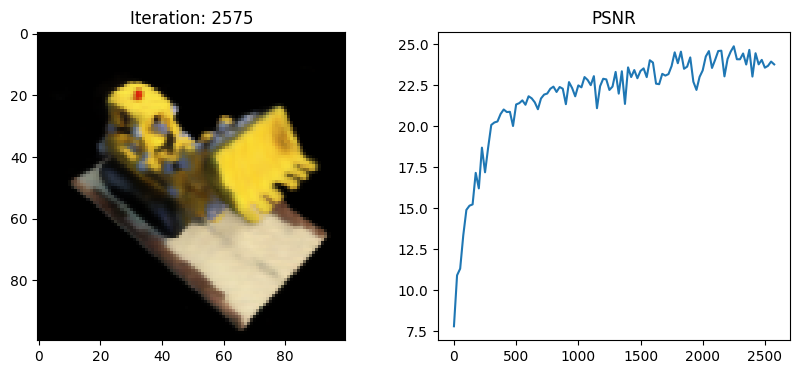

2600 0.6746808242797852 secs per iter


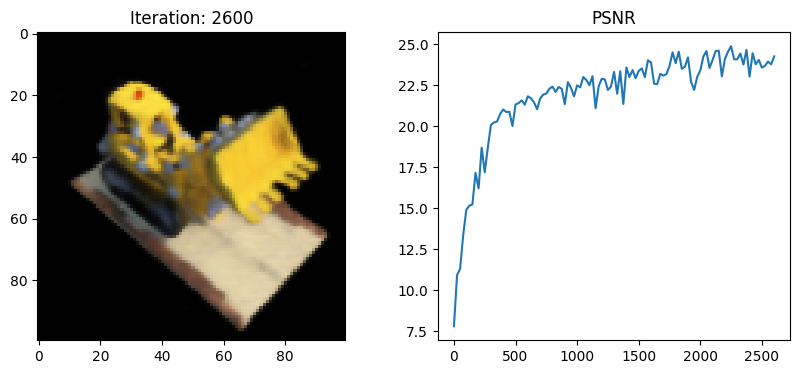

2625 0.6858672142028809 secs per iter


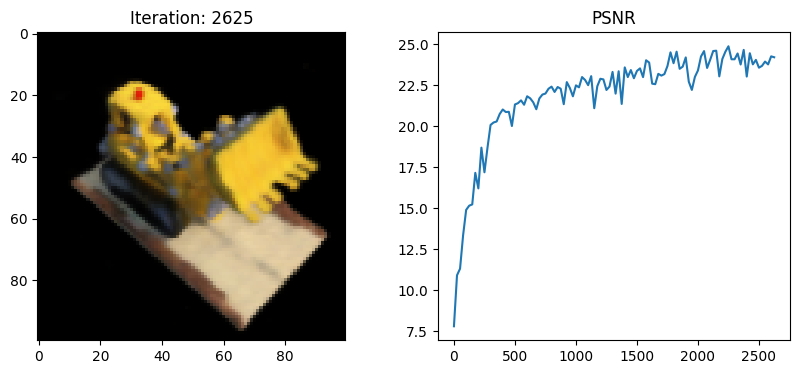

2650 0.731551218032837 secs per iter


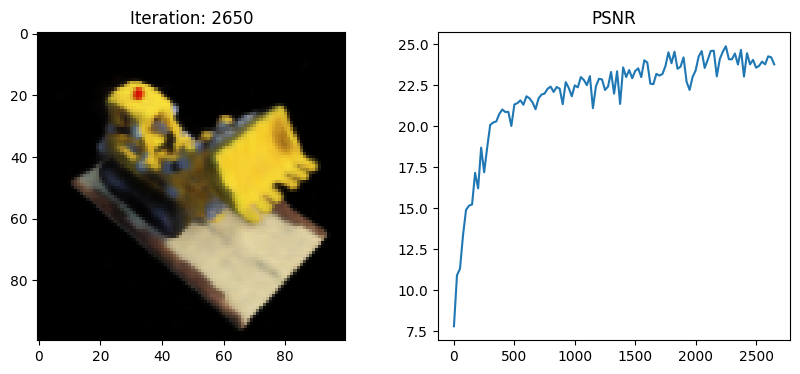

2675 0.6754085826873779 secs per iter


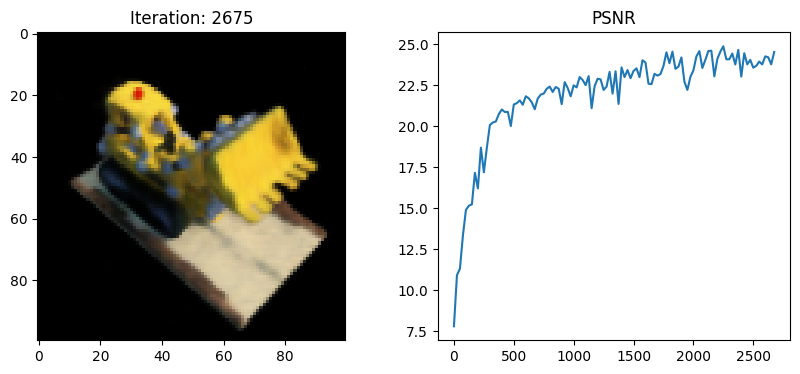

2700 0.6726723575592041 secs per iter


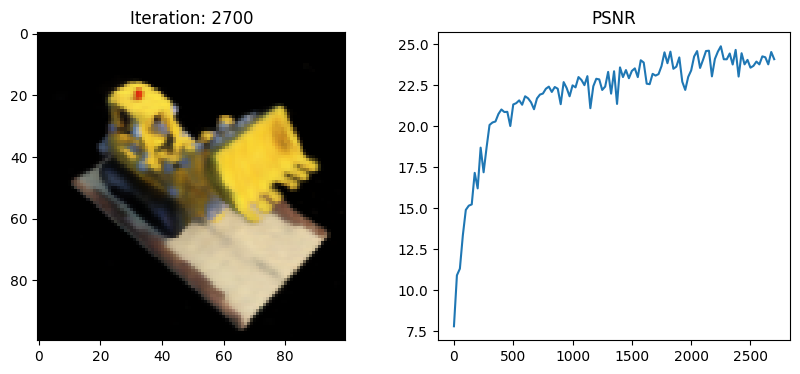

2725 0.6830787754058838 secs per iter


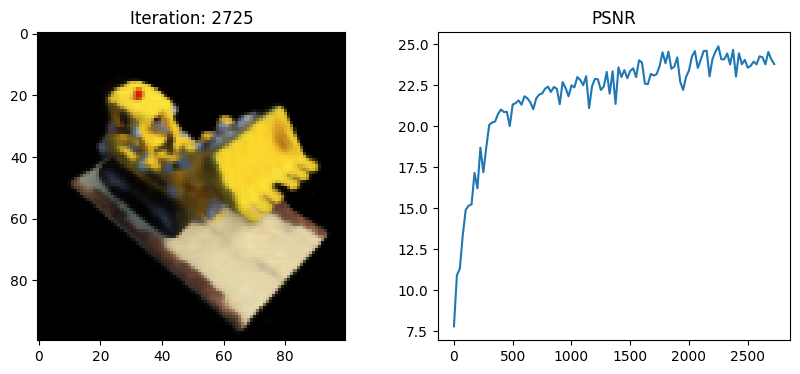

2750 0.6834062099456787 secs per iter


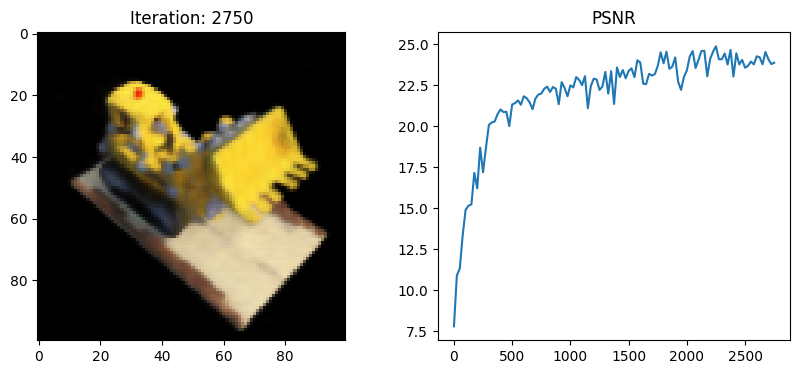

2775 0.6745413398742676 secs per iter


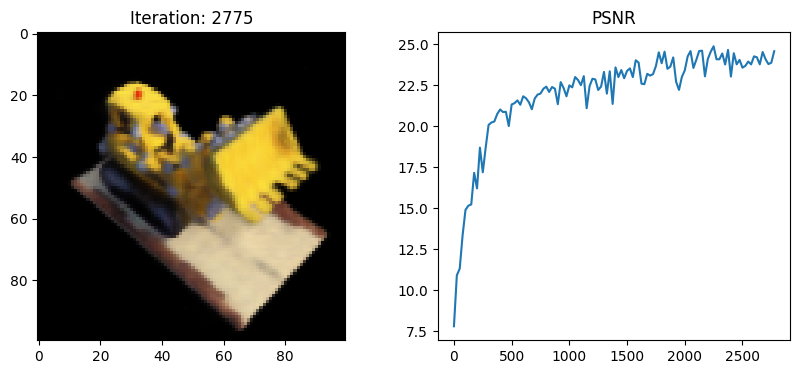

2800 0.6761568737030029 secs per iter


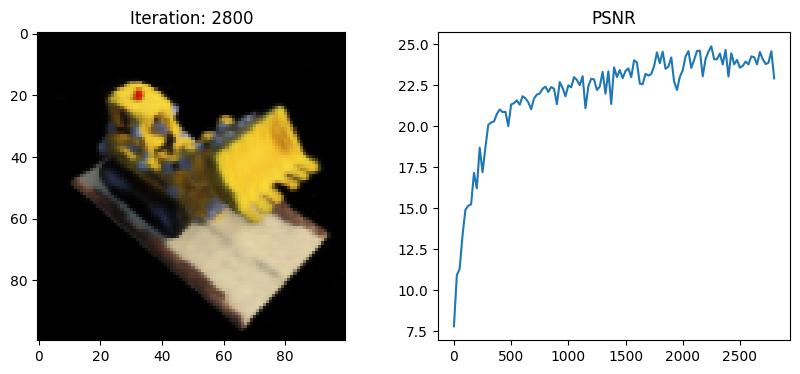

2825 0.6738303756713867 secs per iter


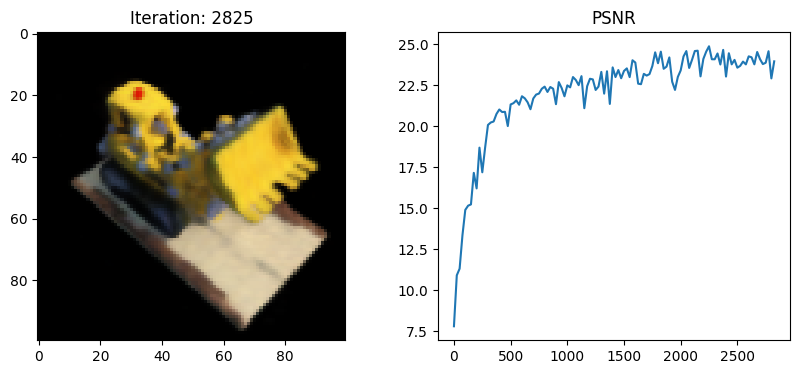

2850 0.711530818939209 secs per iter


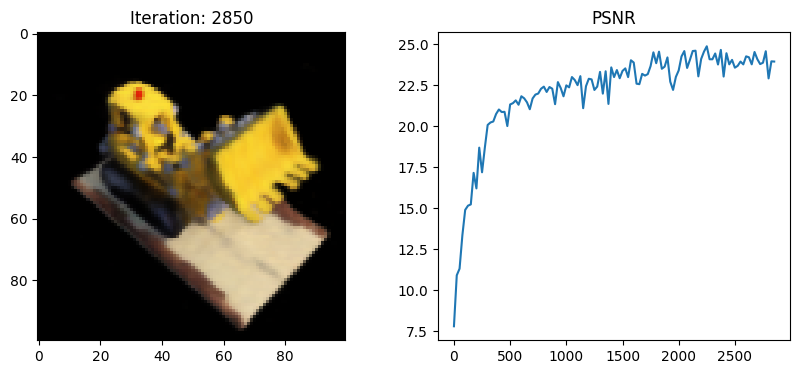

2875 0.6723184299468994 secs per iter


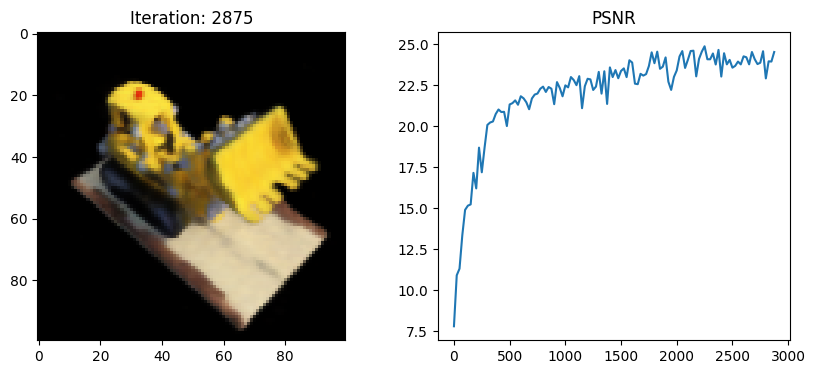

2900 0.6793449211120606 secs per iter


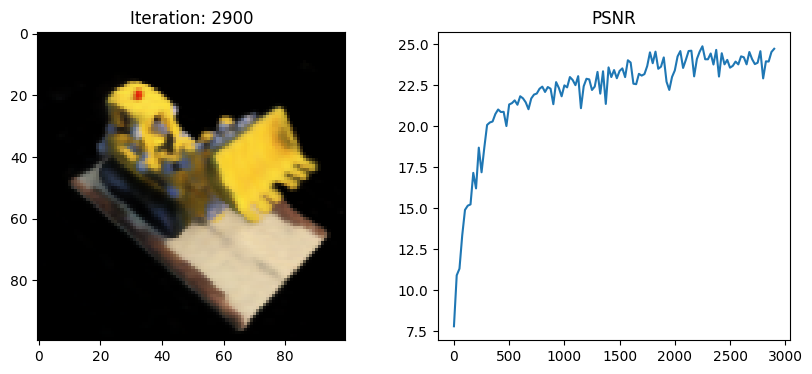

2925 0.7047191238403321 secs per iter


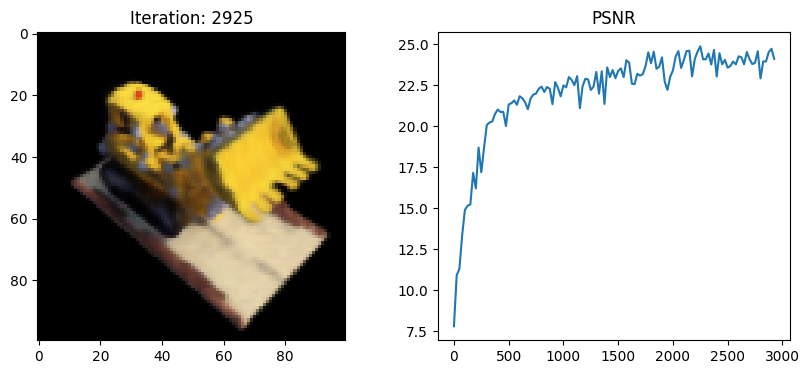

2950 0.6683383464813233 secs per iter


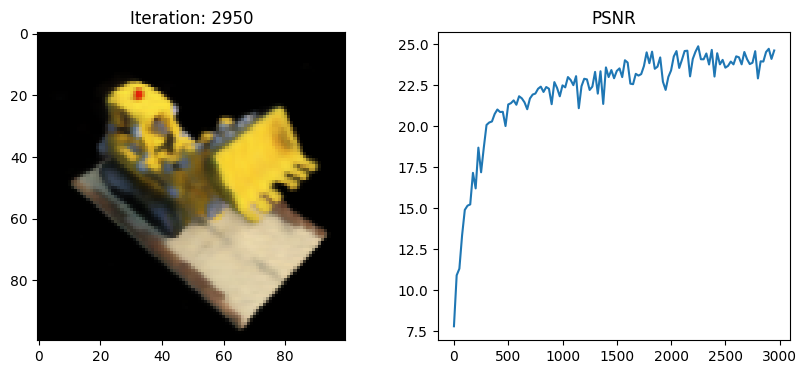

2975 0.6806687355041504 secs per iter


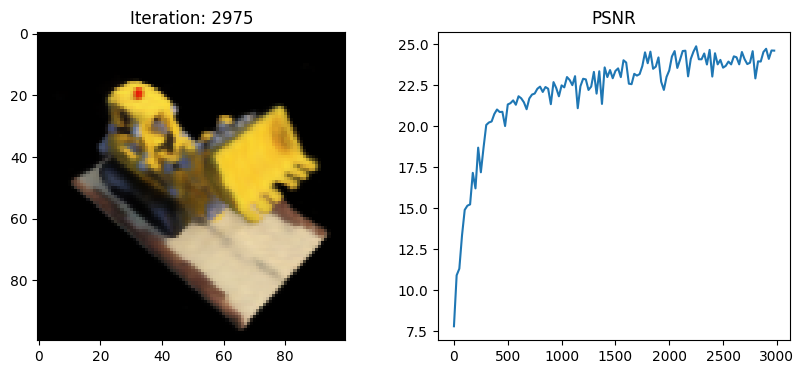

3000 0.6739645862579345 secs per iter


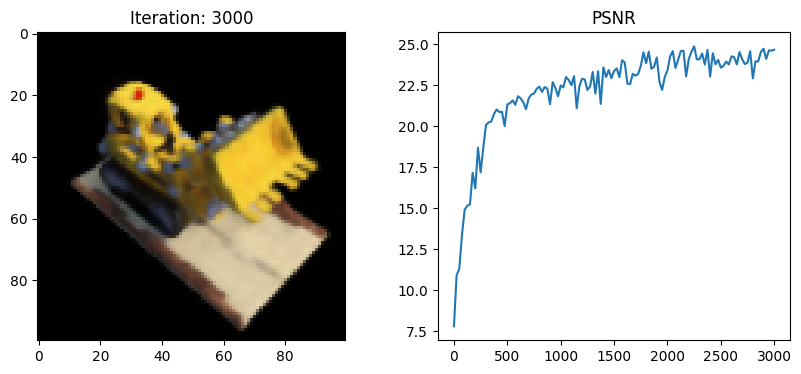

Done


In [5]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 3000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

In [6]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [7]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-7-bc28ed268829>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [8]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)